# Imports

In [1]:
# Install if necessary
%pip install tensorflow
%pip install numpy
%pip install matplotlib
%pip install scikit-image
%pip install scikit-learn
%pip install Pillow
%pip install kagglehub
%pip install xgboost
%pip install seaborn
%pip install pandas
%pip install kaggle

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105797 sha256=4dd25a2cbc24c634d4f278c55ab0e30803197f55e6d7c862cd5a505315f9eadc
  Stored in directory: c:\users\user\appdata\local\packages\pythonsoftwarefoundation.p

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn.decomposition import PCA
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
import kagglehub
from xgboost import XGBClassifier
import seaborn as sns
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Fashion_MNIST

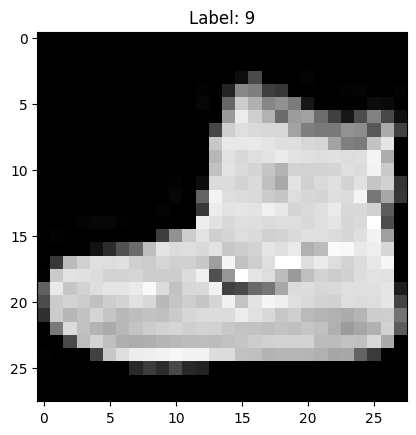

Image size: (28, 28)


In [56]:
# Loading the Fashion-MNIST dataset
def load_fashion_mnist():
    # Using keras
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    # Normalizing the images
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_fashion_mnist()

plt.imshow(x_train[0], cmap='gray')
plt.title(f'Label: {y_train[0]}')
plt.show()
print(f"Image size: {x_train[0].shape}")

# Extract PCA Fashion MNIST

In [57]:
# Extracting PCA features for the Fashion-MNIST dataset
def extract_pca_features(train, test, n_components=17):
    pca = PCA(n_components=n_components)
    pca_train_features = pca.fit_transform(train.reshape(train.shape[0], -1))
    pca_test_features = pca.transform(test.reshape(test.shape[0], -1))

    return pca_train_features, pca_test_features
		

pca_train_features, pca_test_features = extract_pca_features(x_train, x_test)

print(f"PCA Train Features Shape: {pca_train_features.shape}")
print(f"PCA Test Features Shape: {pca_test_features.shape}")

PCA Train Features Shape: (60000, 17)
PCA Test Features Shape: (10000, 17)


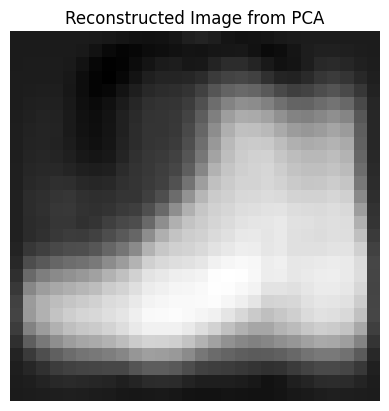

In [58]:
# Test for reconstruction
pca = PCA(n_components=17)
pca.fit(x_train.reshape(len(x_train), -1))  # Flattening

# Reconstructing the first image
first_image_pca = pca_train_features[0].reshape(1, -1)
reconstructed_image = pca.inverse_transform(first_image_pca) 

# Reshaping
reconstructed_image = reconstructed_image.reshape(28, 28)

plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image from PCA')
plt.axis('off')
plt.show()


# Extract HOG Fashion_MNIST

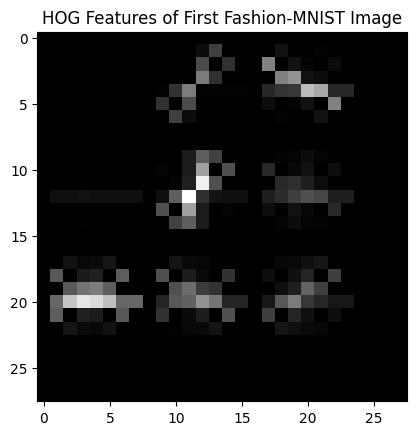

HOG Train Features Shape: (60000, 144)
HOG Test Features Shape: (10000, 144)


In [ ]:
# Extracting HOG features for Fashion-MNIST
def extract_hog_features(image, cells_per_block=(2, 2), visualization=False):
    if visualization:
        fd, hog_image = hog(image,
                            cells_per_block=cells_per_block, visualize=True)

        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        return fd, hog_image_rescaled
    else:
        fd = hog(image, cells_per_block=cells_per_block)
        return fd, None


fd, hog_image_rescaled = extract_hog_features(x_train[0], visualization=True)
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.title('HOG Features of First Fashion-MNIST Image')
plt.show()

hog_train_features = np.array([extract_hog_features(img)[0] for img in x_train])
hog_test_features = np.array([extract_hog_features(img)[0] for img in x_test])

print(f"HOG Train Features Shape: {hog_train_features.shape}")
print(f"HOG Test Features Shape: {hog_test_features.shape}")

# Combine Fashion_MNIST

In [ ]:
# Combining PCA and HOG features for Fashion MNIST
def combine_pca_hog_features(pca_features, hog_features):
    return np.hstack((pca_features, hog_features))

combined_train_features_fashion = combine_pca_hog_features(pca_train_features, hog_train_features)
combined_test_features_fashion = combine_pca_hog_features(pca_test_features, hog_test_features)

print(f"Combined Train Features Shape (Fashion MNIST): {combined_train_features_fashion.shape}")
print(f"Combined Test Features Shape (Fashion MNIST): {combined_test_features_fashion.shape}")

Combined Train Features Shape (Fashion MNIST): (60000, 161)
Combined Test Features Shape (Fashion MNIST): (10000, 161)


# Load Fruits-360

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\moltean\fruits\versions\11
Training images shape: (70491, 28, 28, 3)
Testing images shape: (23619, 28, 28, 3)


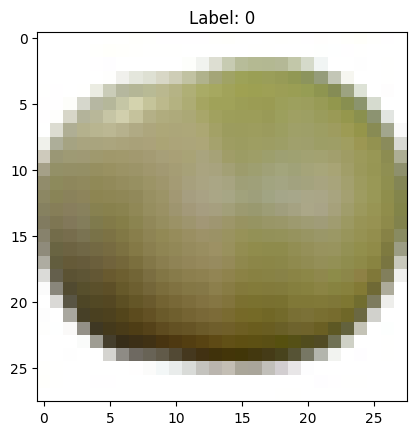

In [ ]:
# Downloading the dataset using kagglehub
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

# Defining the full paths for Training and Testing directories
train_dir = os.path.join(path, 'fruits-360_dataset_100x100/fruits-360/Training')
test_dir = os.path.join(path, 'fruits-360_dataset_100x100/fruits-360/Test')

def load_fruits_from_directory(directory, image_size=(28, 28)):
    images = []
    labels = []
    label_map = {}
    label = 0

    for fruit in os.listdir(directory):
        fruit_path = os.path.join(directory, fruit)
        if os.path.isdir(fruit_path):
            label_map[label] = fruit
            for image_file in os.listdir(fruit_path):
                image_path = os.path.join(fruit_path, image_file)
                image = Image.open(image_path)
                image = image.resize(image_size)
                image = np.array(image)

                images.append(image)
                labels.append(label)
            label += 1

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_map

x_train_fruits, y_train_fruits, label_map_train = load_fruits_from_directory(train_dir)
x_test_fruits, y_test_fruits, label_map_test = load_fruits_from_directory(test_dir)

print(f"Training images shape: {x_train_fruits.shape}")
print(f"Testing images shape: {x_test_fruits.shape}")

plt.imshow(x_train_fruits[100], cmap='gray')
plt.title(f'Label: {y_train_fruits[100]}')
plt.show()

# Extract PCA Fruits-360

In [ ]:
# Extracting PCA features for Fruits-360
def extract_pca_features(train, test, n_components=17):
    pca = PCA(n_components=n_components)
    pca_train_features = pca.fit_transform(train.reshape(train.shape[0], -1))
    pca_test_features = pca.transform(test.reshape(test.shape[0], -1))

    return pca_train_features, pca_test_features

pca_train_features_fruits, pca_test_features_fruits = extract_pca_features(x_train_fruits, x_test_fruits)

print(f"PCA Train Features (Fruits-360) Shape: {pca_train_features_fruits.shape}")
print(f"PCA Test Features (Fruits-360) Shape: {pca_test_features_fruits.shape}")

PCA Train Features (Fruits-360) Shape: (70491, 17)
PCA Test Features (Fruits-360) Shape: (23619, 17)


# Extract HOG Fruits-360

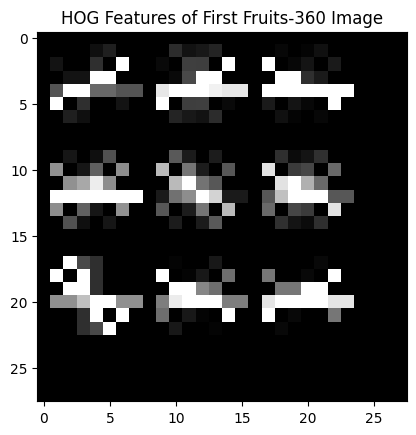

HOG Train Features (Fruits-360) Shape: (70491, 144)
HOG Test Features (Fruits-360) Shape: (23619, 144)


In [ ]:
# Extracting HOG features for Fruits-360
def extract_hog_features_fruits(image, cells_per_block=(2, 2), visualization=False):
    if visualization:
        fd, hog_image = hog(image,
                            cells_per_block=cells_per_block, visualize=True, channel_axis=-1)

        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        return fd, hog_image_rescaled
    else:
        fd = hog(image, cells_per_block=cells_per_block, channel_axis=-1)
        return fd, None

fd, hog_image_rescaled_fruits = extract_hog_features_fruits(x_train_fruits[100], visualization=True)
plt.imshow(hog_image_rescaled_fruits, cmap=plt.cm.gray)
plt.title('HOG Features of First Fruits-360 Image')
plt.show()

hog_train_features_fruits = np.array([extract_hog_features_fruits(img)[0] for img in x_train_fruits])
hog_test_features_fruits = np.array([extract_hog_features_fruits(img)[0] for img in x_test_fruits])

print(f"HOG Train Features (Fruits-360) Shape: {hog_train_features_fruits.shape}")
print(f"HOG Test Features (Fruits-360) Shape: {hog_test_features_fruits.shape}")

# Combine Fruits-360

In [ ]:
# Combining PCA and HOG features for Fruits-360
def combine_pca_hog_features_fruits(pca_features, hog_features):
    return np.hstack((pca_features, hog_features))

combined_train_features_fruits = combine_pca_hog_features_fruits(pca_train_features_fruits, hog_train_features_fruits)
combined_test_features_fruits = combine_pca_hog_features_fruits(pca_test_features_fruits, hog_test_features_fruits)

print(f"Combined Train Features Shape (Fruits-360): {combined_train_features_fruits.shape}")
print(f"Combined Test Features Shape (Fruits-360): {combined_test_features_fruits.shape}")

Combined Train Features Shape (Fruits-360): (70491, 161)
Combined Test Features Shape (Fruits-360): (23619, 161)


# Visualize Distribution

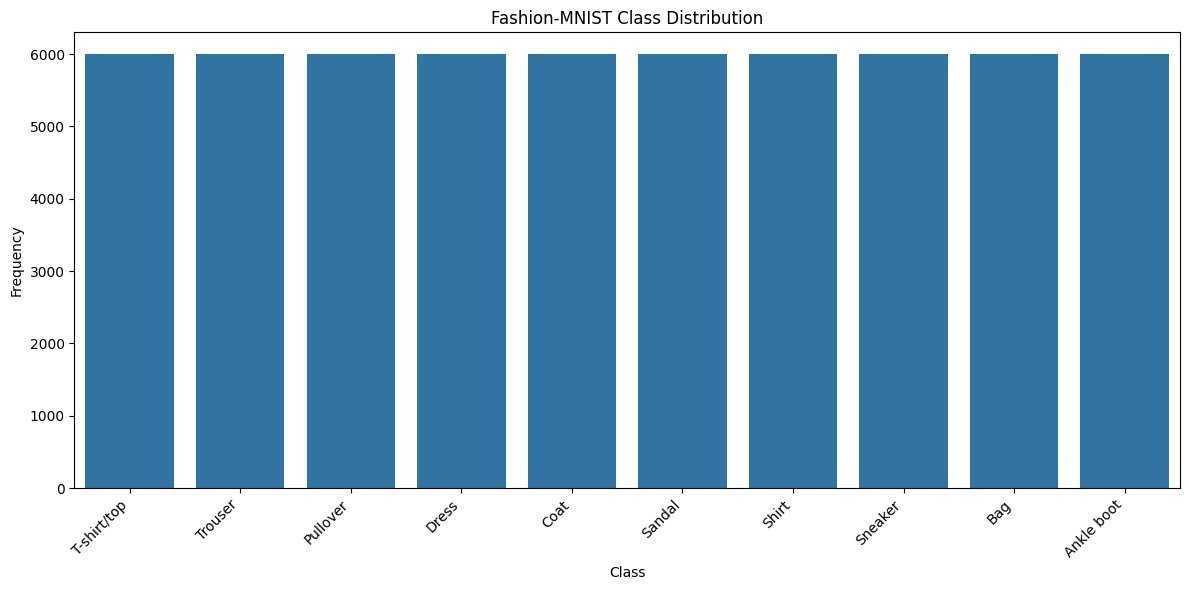

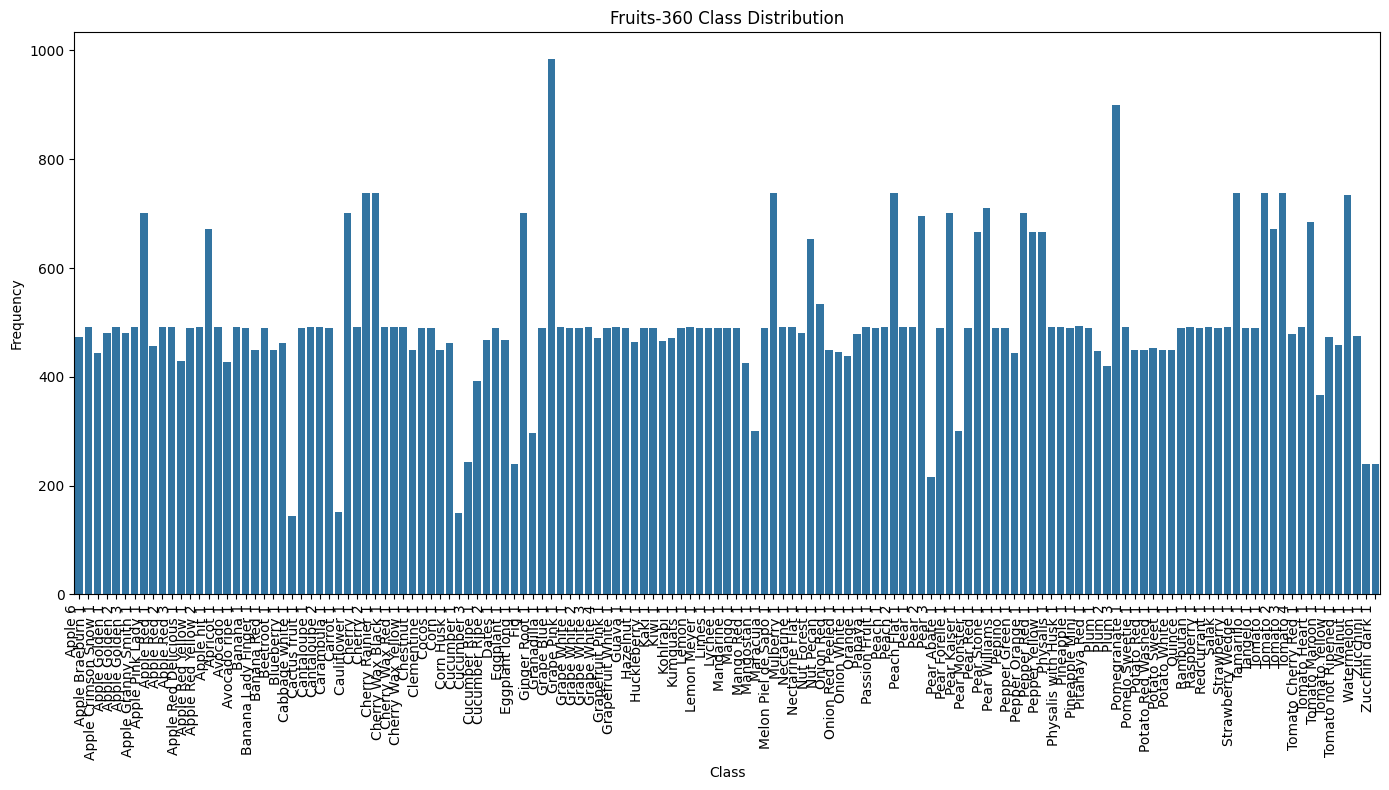

In [ ]:
# Fashion-MNIST class distribution
fashion_labels = pd.Series(y_train).value_counts().sort_index()

# List of class labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=fashion_labels.values)
plt.xticks(rotation=45, ha="right")
plt.title('Fashion-MNIST Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Fruits-360 class distribution
fruits_labels = pd.Series(y_train_fruits).value_counts().sort_index()

plt.figure(figsize=(14, 8)) 
sorted_label = {k: v for k, v in sorted(label_map_train.items(), key=lambda item: item[1])}
sns.barplot(x=list(sorted_label.values()), y=fruits_labels.values)
plt.xticks(rotation=90, ha="right")
plt.title('Fruits-360 Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


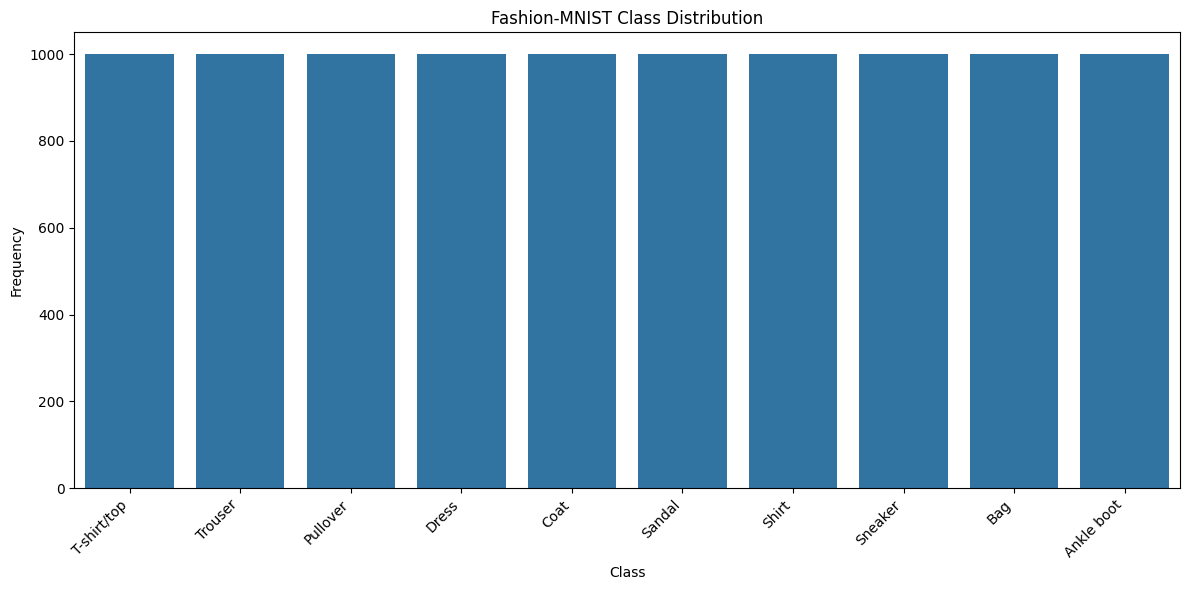

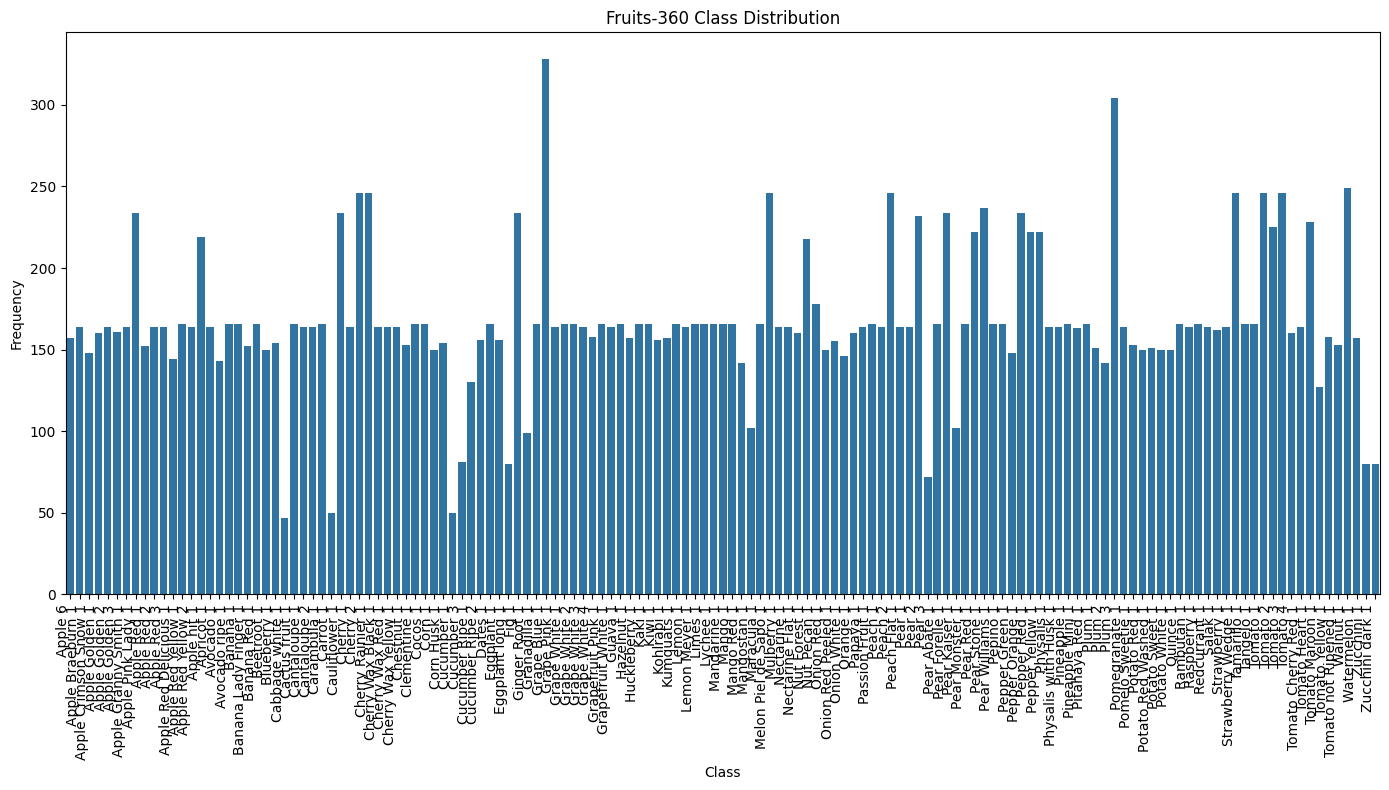

In [59]:
# Fashion-MNIST class distribution
fashion_labels = pd.Series(y_test).value_counts().sort_index()

# List of class labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=fashion_labels.values)
plt.xticks(rotation=45, ha="right")
plt.title('Fashion-MNIST Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Fruits-360 class distribution
fruits_labels = pd.Series(y_test_fruits).value_counts().sort_index()

plt.figure(figsize=(14, 8)) 
sorted_label = {k: v for k, v in sorted(label_map_test.items(), key=lambda item: item[1])}
sns.barplot(x=list(sorted_label.values()), y=fruits_labels.values)
plt.xticks(rotation=90, ha="right")
plt.title('Fruits-360 Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Visualize HOG

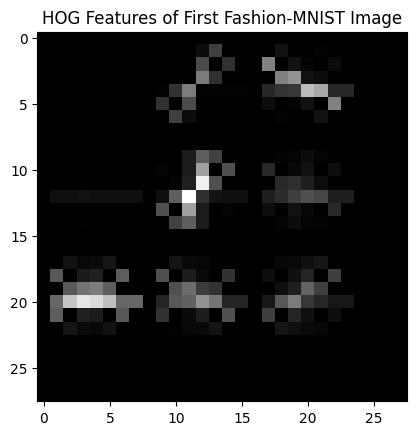

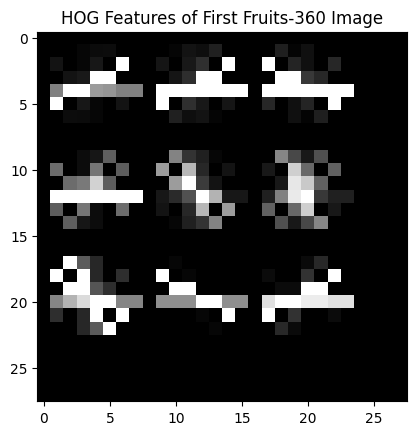

In [ ]:
fd, hog_image_rescaled = extract_hog_features(x_train[0], visualization=True)  # Fashion-MNIST
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
plt.title('HOG Features of First Fashion-MNIST Image')
plt.show()

fd, hog_image_rescaled_fruits = extract_hog_features_fruits(x_train_fruits[0], visualization=True)  # Fruits-360
plt.imshow(hog_image_rescaled_fruits, cmap=plt.cm.gray)
plt.title('HOG Features of First Fruits-360 Image')
plt.show()

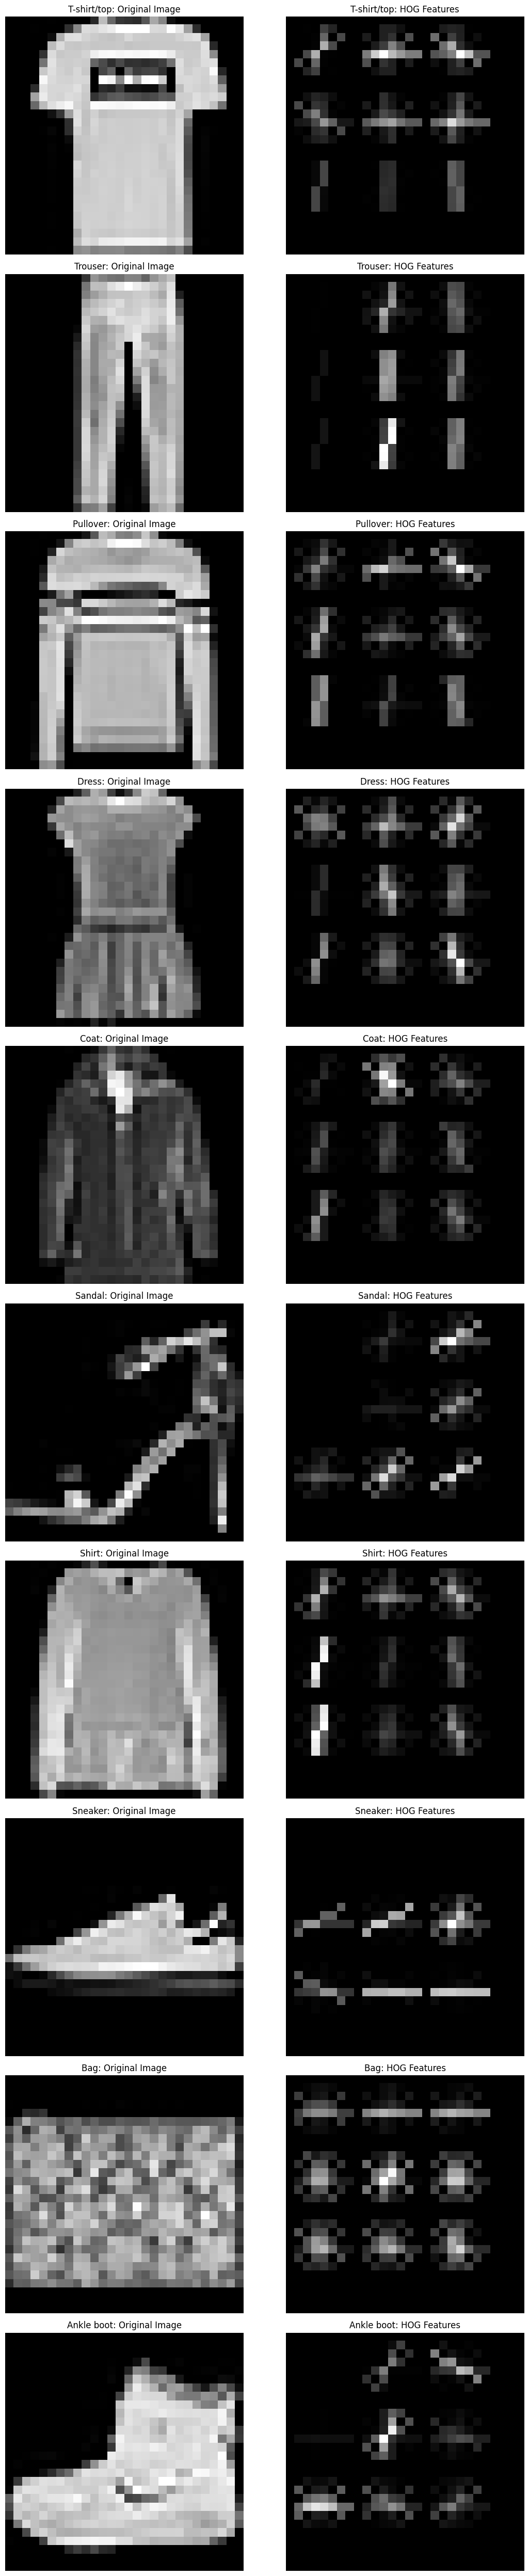

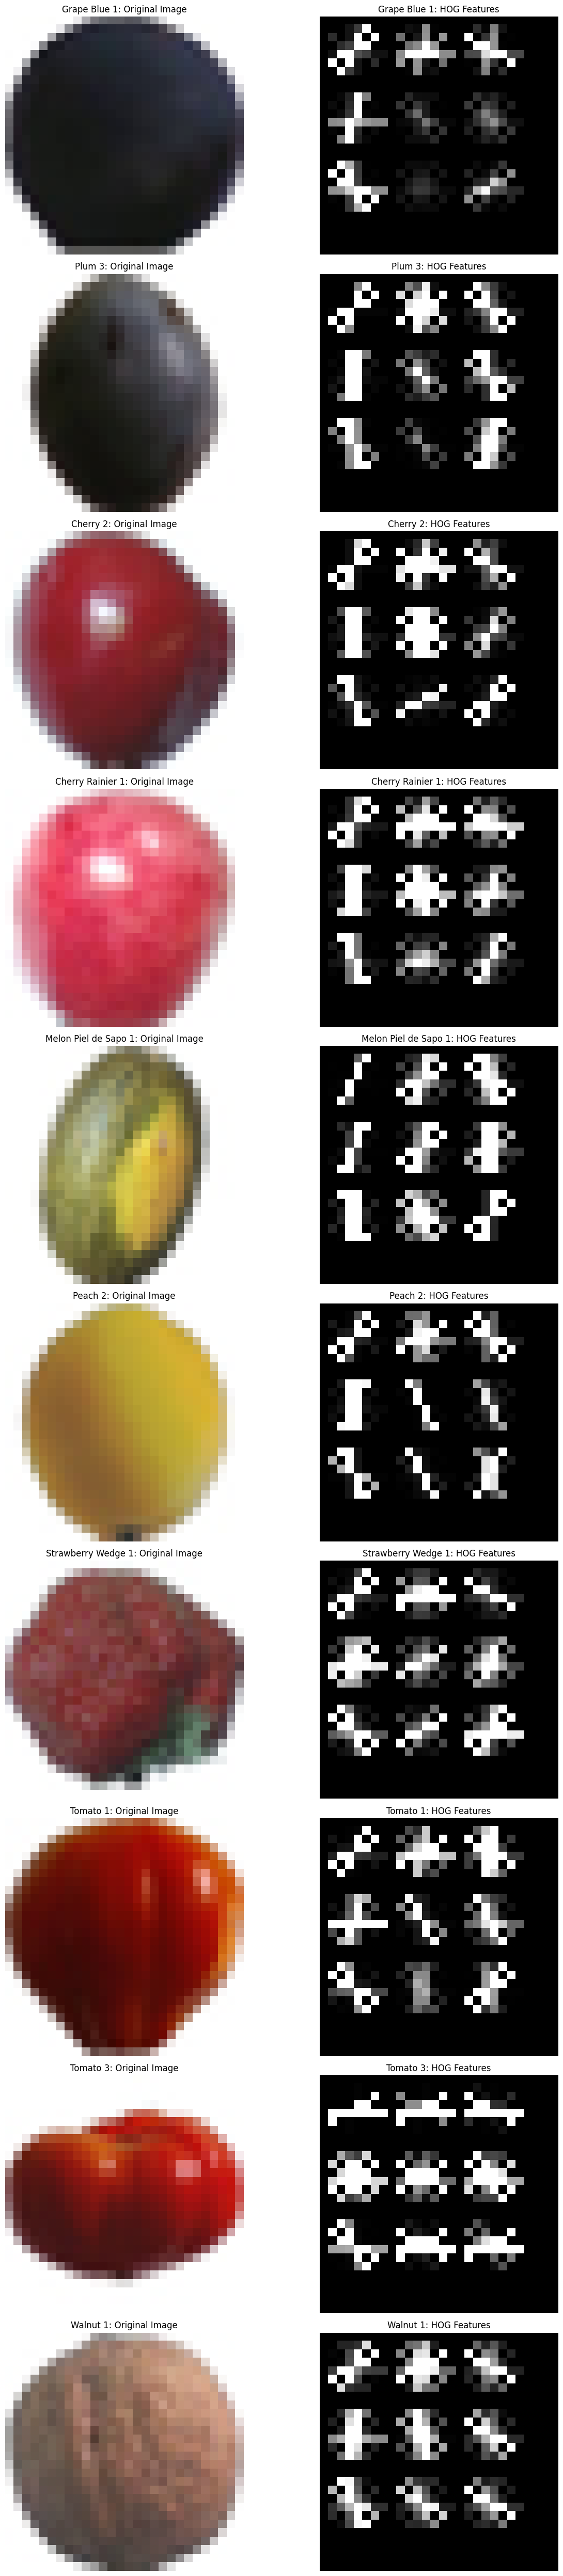

In [52]:
def extract_hog_features(image, cells_per_block=(2, 2), visualization=False, grayscale=True):
    if not grayscale:
        channel_axis = -1
    else:
        channel_axis = None

    if visualization:
        fd, hog_image = hog(image, cells_per_block=cells_per_block, channel_axis=channel_axis, visualize=True)
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        return fd, hog_image_rescaled
    else:
        fd = hog(image, cells_per_block=cells_per_block, channel_axis=channel_axis)
        return fd, None

def visualize_hog_fashion_mnist(x_train, y_train, class_names, n_classes=10):
    # Convert class_names to a list if it is a set
    class_names = list(class_names)
    
    # Number of rows for subplots
    rows = (n_classes * 2 + 1) // 2
    
    plt.figure(figsize=(12, rows * 5))
    
    for i in range(n_classes):
        class_samples = np.where(y_train == i)[0]
        sample_image = x_train[class_samples[0]]

        _, hog_image_rescaled = extract_hog_features(sample_image, visualization=True)
        
        plt.subplot(rows, 2, i * 2 + 1)  # Original image
        plt.imshow(sample_image, cmap=plt.cm.gray)
        plt.title(f'{class_names[i]}: Original Image')
        plt.axis('off')
        
        plt.subplot(rows, 2, i * 2 + 2)  # HOG features image
        plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        plt.title(f'{class_names[i]}: HOG Features')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# For Fruits-360, find the top 10 most frequent classes and visualize HOG features with class names
def visualize_hog_fruits(x_train_fruits, y_train_fruits, label_map_train, n_top_classes=10, grayscale=True):    
    # Sort classes by frequency and select the top n classes
    unique, counts = np.unique(y_train_fruits, return_counts=True)
    class_counts = dict(zip(unique, counts))
    sorted_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:n_top_classes]

    # Sort the label map alphabetically by label name
    sorted_label = {k: v for k, v in sorted(label_map_train.items(), key=lambda item: item[1])}

    rows = (n_top_classes * 2 + 1) // 2
    
    plt.figure(figsize=(14, rows * 5))
    
    for i, class_idx in enumerate(sorted_classes):
        class_samples = np.where(y_train_fruits == class_idx)[0]
        sample_image = x_train_fruits[class_samples[0]]

        _, hog_image_rescaled = extract_hog_features(sample_image, visualization=True, grayscale=grayscale)
        
        plt.subplot(rows, 2, i * 2 + 1)  # Original image
        plt.imshow(sample_image)
        plt.title(f'{sorted_label[class_idx]}: Original Image')
        plt.axis('off')
        
        plt.subplot(rows, 2, i * 2 + 2)  # HOG features image
        plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        plt.title(f'{sorted_label[class_idx]}: HOG Features')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

visualize_hog_fashion_mnist(x_train, y_train, class_names, n_classes=10)
visualize_hog_fruits(x_train_fruits, y_train_fruits, label_map_train, n_top_classes=10, grayscale=False)

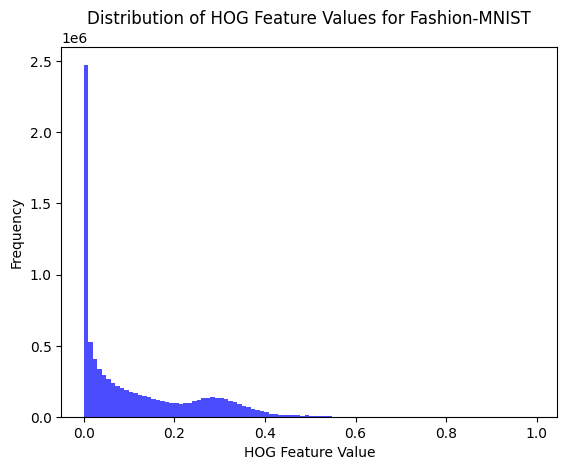

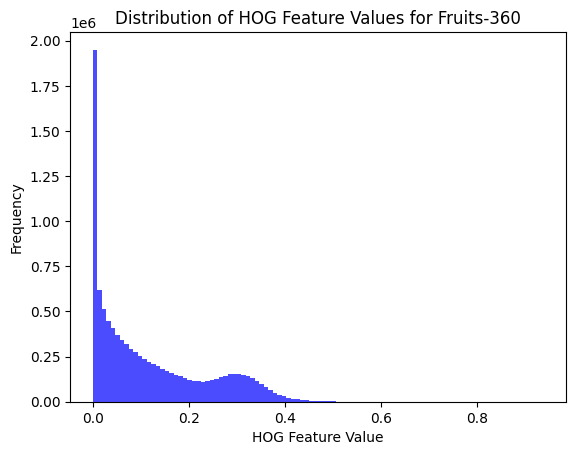

In [ ]:
# Calculate and visualize the distribution of the HOG feature values for Fashion-MNIST
plt.hist(hog_train_features.flatten(), bins=100, color='blue', alpha=0.7)
plt.xlabel('HOG Feature Value')
plt.ylabel('Frequency')
plt.title('Distribution of HOG Feature Values for Fashion-MNIST')
plt.show()

# Calculate and visualize the distribution of the HOG feature values for Fruits-360
plt.hist(hog_train_features_fruits.flatten(), bins=100, color='blue', alpha=0.7)
plt.xlabel('HOG Feature Value')
plt.ylabel('Frequency')
plt.title('Distribution of HOG Feature Values for Fruits-360')
plt.show()


# Visualize PCA

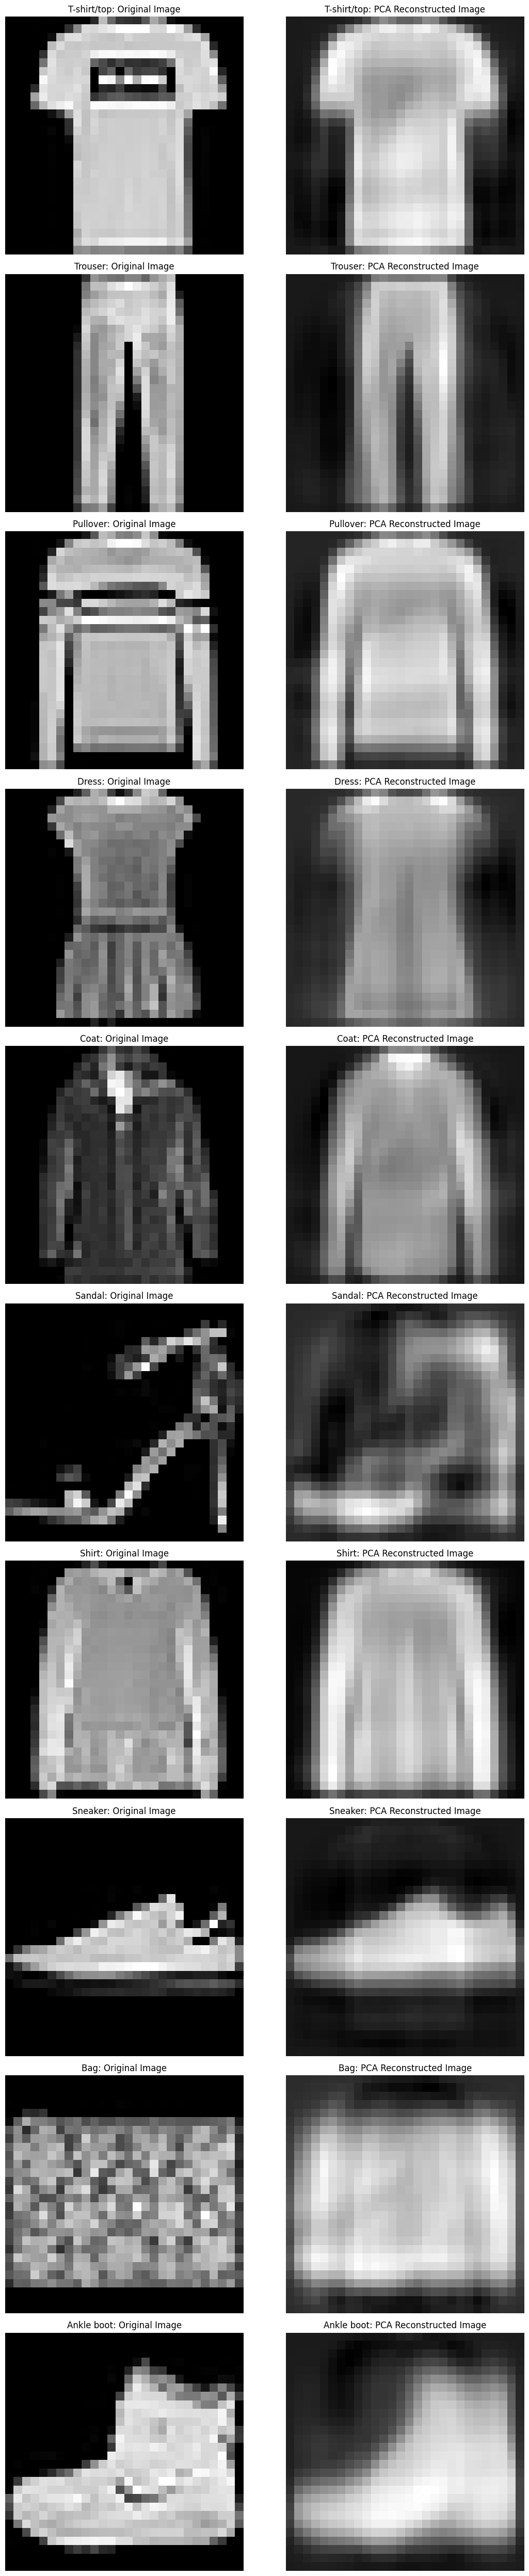

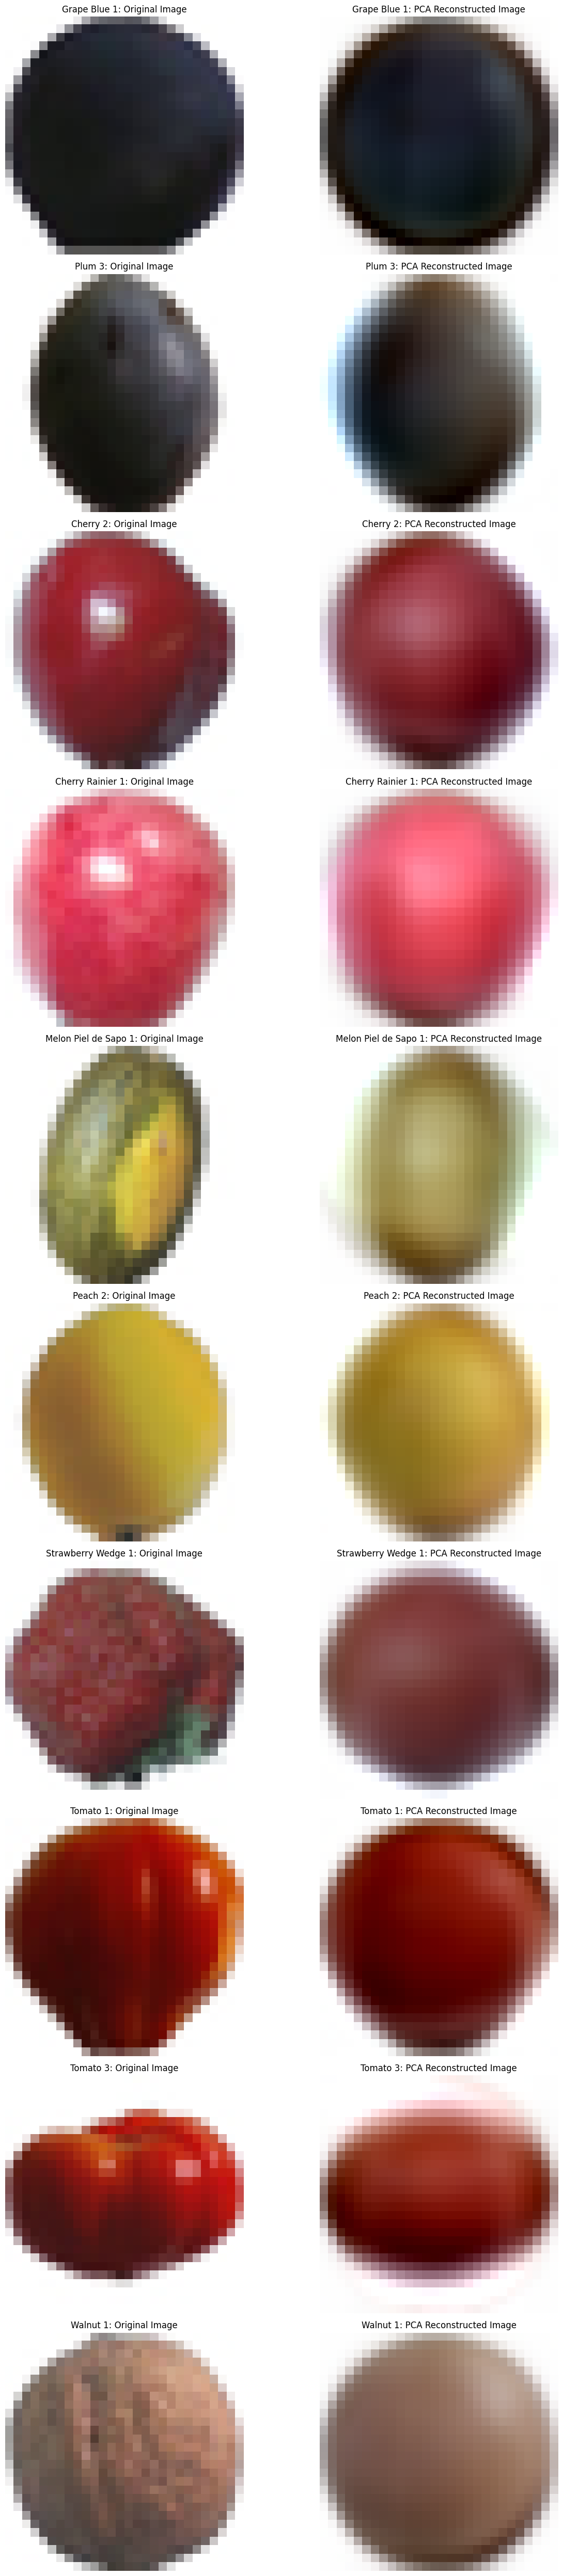

In [53]:
def visualize_pca_fashion_mnist(x_train, y_train, class_names, n_classes=10, n_components=17, original_shape=(28, 28)):
    plt.figure(figsize=(12, n_classes * 5))
    
    for i in range(n_classes):
        class_samples = np.where(y_train == i)[0]
        sample_image = x_train[class_samples[0]] 

        pca = PCA(n_components=n_components)
        pca.fit(x_train.reshape(len(x_train), -1))

        image_pca_features = pca.transform(sample_image.reshape(1, -1))

        reconstructed_image = pca.inverse_transform(image_pca_features)
        
        reconstructed_image = reconstructed_image.reshape(original_shape)

        plt.subplot(n_classes, 2, i * 2 + 1)  # Original image
        plt.imshow(sample_image, cmap='gray')
        plt.title(f'{class_names[i]}: Original Image')
        plt.axis('off')
        
        plt.subplot(n_classes, 2, i * 2 + 2)  # PCA-reconstructed image
        plt.imshow(reconstructed_image, cmap='gray')
        plt.title(f'{class_names[i]}: PCA Reconstructed Image')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to visualize PCA for Fruits-360 (top 10 most common classes)
def visualize_pca_fruits(x_train_fruits, y_train_fruits, label_map_train, n_top_classes=10, n_components=17, grayscale=False):
    # Sort classes by frequency and select the top n classes
    unique, counts = np.unique(y_train_fruits, return_counts=True)
    class_counts = dict(zip(unique, counts))
    sorted_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:n_top_classes]

    # Sort the label map alphabetically by label name
    sorted_label = {k: v for k, v in sorted(label_map_train.items(), key=lambda item: item[1])}

    plt.figure(figsize=(14, n_top_classes * 5))
    
    for i, class_idx in enumerate(sorted_classes):
        class_samples = np.where(y_train_fruits == class_idx)[0]
        sample_image = x_train_fruits[class_samples[0]]
        
        pca = PCA(n_components=n_components)
        pca.fit(x_train_fruits.reshape(len(x_train_fruits), -1))
        
        image_pca_features = pca.transform(sample_image.reshape(1, -1))

        reconstructed_image = pca.inverse_transform(image_pca_features)
        
        # Clipping and converting values to uint8
        reconstructed_image = np.clip(reconstructed_image, 0, 255)
        reconstructed_image = reconstructed_image.astype(np.uint8)

        reconstructed_image = reconstructed_image.reshape(sample_image.shape)
        
        plt.subplot(n_top_classes, 2, i * 2 + 1)  # Original image
        plt.imshow(sample_image)
        plt.title(f'{sorted_label[class_idx]}: Original Image')
        plt.axis('off')
        
        plt.subplot(n_top_classes, 2, i * 2 + 2)  # PCA-reconstructed image
        plt.imshow(reconstructed_image)
        plt.title(f'{sorted_label[class_idx]}: PCA Reconstructed Image')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
visualize_pca_fashion_mnist(x_train, y_train, class_names, n_classes=10, n_components=17, original_shape=(28, 28))

visualize_pca_fruits(x_train_fruits, y_train_fruits, label_map_train, n_top_classes=10, n_components=17, grayscale=False)

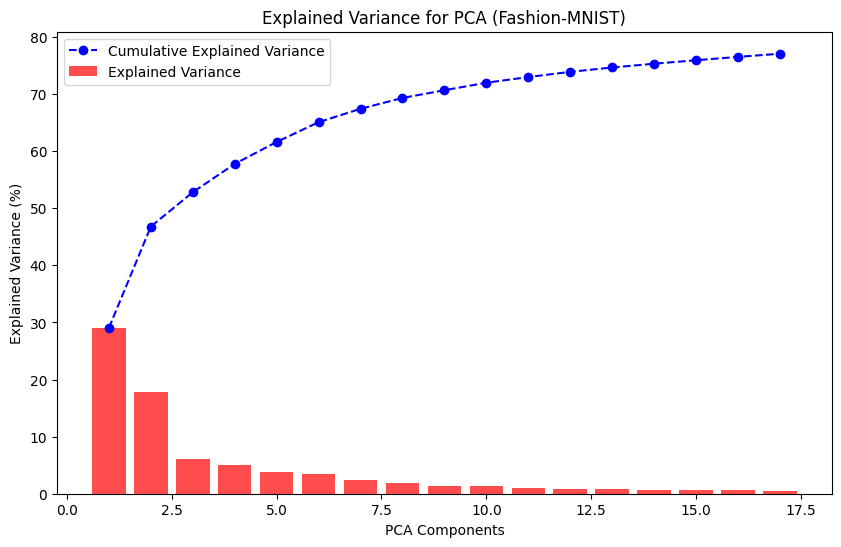

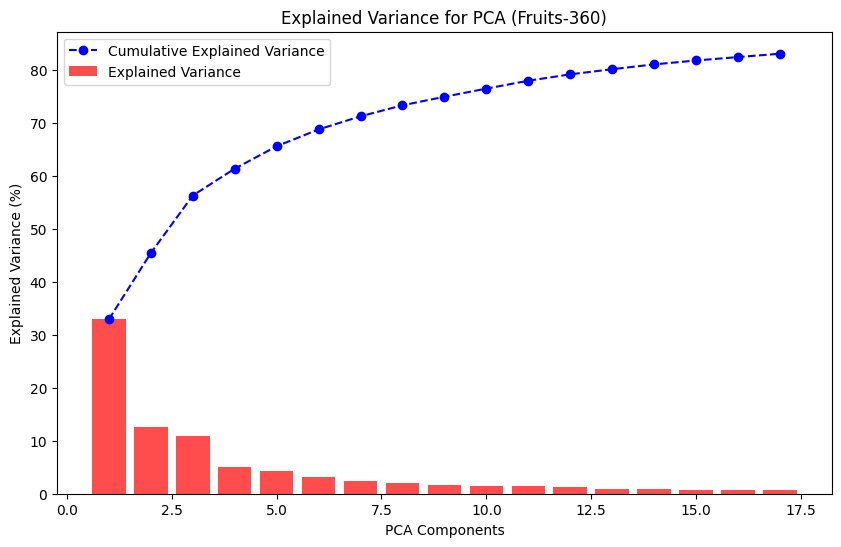

In [54]:
# Apply PCA to Fashion-MNIST dataset
pca = PCA(n_components=17)
principal_components = pca.fit_transform(x_train.reshape(len(x_train), -1))

# Explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_ * 100
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))

# Cumulative explained variance plot
plt.plot(range(1, 18), cumulative_explained_variance, marker='o', linestyle='--', color='b', label='Cumulative Explained Variance')

# Individual explained variance for each component
plt.bar(range(1, 18), explained_variance, alpha=0.7, color='r', label='Explained Variance')

plt.xlabel('PCA Components')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance for PCA (Fashion-MNIST)')
plt.legend(loc='best')
plt.show()

# Apply PCA to Fruit-360 dataset
pca_fruits = PCA(n_components=17)
principal_components_fruits = pca_fruits.fit_transform(x_train_fruits.reshape(len(x_train_fruits), -1))

# Explained variance ratio for each component
explained_variance_fruits = pca_fruits.explained_variance_ratio_ * 100
cumulative_explained_variance_fruits = np.cumsum(explained_variance_fruits)

# Plot cumulative explained variance and individual explained variance
plt.figure(figsize=(10, 6))

# Cumulative explained variance plot
plt.plot(range(1, 18), cumulative_explained_variance_fruits, marker='o', linestyle='--', color='b', label='Cumulative Explained Variance')

# Individual explained variance for each component
plt.bar(range(1, 18), explained_variance_fruits, alpha=0.7, color='r', label='Explained Variance')

plt.xlabel('PCA Components')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance for PCA (Fruits-360)')
plt.legend(loc='best')
plt.show()


# Standardization

In [ ]:
# Standardize the combined features for Fashion-MNIST
scaler = StandardScaler()
combined_train_features_scaled_fashion = scaler.fit_transform(combined_train_features_fashion)
combined_test_features_scaled_fashion = scaler.transform(combined_test_features_fashion)

# Standardize the combined features for Fruits-360
scaler_fruits = StandardScaler()
combined_train_features_scaled_fruits = scaler_fruits.fit_transform(combined_train_features_fruits)
combined_test_features_scaled_fruits = scaler_fruits.transform(combined_test_features_fruits)

# Feature selection

In [ ]:
# Applying Variance Thresholding to reduce the number of features
selector = VarianceThreshold(threshold=0.01)
reduced_train_features_fashion = selector.fit_transform(combined_train_features_scaled_fashion, y_train)
reduced_test_features_fashion = selector.transform(combined_test_features_scaled_fashion)

print(f"Original Train Features Shape: {combined_train_features_scaled_fashion.shape}")
print(f"Reduced Train Features Shape: {reduced_train_features_fashion.shape}")

# Applying Variance Thresholding to reduce the number of features for Fruits-360
selector_fruits = VarianceThreshold(threshold=0.01)
reduced_train_features_fruits = selector_fruits.fit_transform(combined_train_features_scaled_fruits, y_train_fruits)
reduced_test_features_fruits = selector_fruits.transform(combined_test_features_scaled_fruits)

# Print the shape of the reduced features
print(f"Original Train Features Shape: {combined_train_features_scaled_fruits.shape}")
print(f"Reduced Train Features Shape: {reduced_train_features_fruits.shape}")

Original Train Features Shape: (60000, 161)
Reduced Train Features Shape: (60000, 161)
Original Train Features Shape: (70491, 161)
Reduced Train Features Shape: (70491, 161)


# Tuning

## Logistic Regression

In [ ]:
param_dist_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'multi_class': ['ovr', 'multinomial'],  # Multi-class classification methodology
	'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization penalty
	'solver': ['saga', 'liblinear', 'newton-cg', 'lbfgs', 'sag', 'newton-cg', 'newton-cholesky'],  # Optimization algorithm
}

lr = LogisticRegression(max_iter=1000)

random_search_lr = RandomizedSearchCV(lr, param_distributions=param_dist_lr, n_iter=10, cv=3, n_jobs=-1, verbose=1)

random_search_lr.fit(reduced_train_features_fashion, y_train)

print("Best Parameters for Logistic Regression:", random_search_lr.best_params_)
print("Best Score for Logistic Regression:", random_search_lr.best_score_)

# Top 5 best parameters for Logistic Regression
# Sorting the results by mean_test_score in descending order
results_df = pd.DataFrame(random_search_lr.cv_results_)
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

print(results_df[['params', 'mean_test_score']].head(5))

lr = LogisticRegression(max_iter=1000)

random_search_lr = RandomizedSearchCV(lr, param_distributions=param_dist_lr, n_iter=10, cv=3, n_jobs=-1, verbose=1)

random_search_lr.fit(reduced_train_features_fruits, y_train_fruits)

print("Best Parameters for Logistic Regression:", random_search_lr.best_params_)
print("Best Score for Logistic Regression:", random_search_lr.best_score_)

# Top 5 best parameters for Logistic Regression
# Sort the results by mean_test_score in descending order
results_df = pd.DataFrame(random_search_lr.cv_results_)

results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

print(results_df[['params', 'mean_test_score']].head(5))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
18 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages

Best Parameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'C': 10}
Best Score for Logistic Regression: 0.8594
                                              params  mean_test_score
3  {'solver': 'lbfgs', 'penalty': 'l2', 'multi_cl...         0.859400
4  {'solver': 'liblinear', 'penalty': 'l1', 'mult...         0.855183
2  {'solver': 'liblinear', 'penalty': 'l2', 'mult...         0.855133
7  {'solver': 'newton-cg', 'penalty': 'l2', 'mult...         0.853283
0  {'solver': 'liblinear', 'penalty': 'l2', 'mult...              NaN
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages

Best Parameters for Logistic Regression: {'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'multinomial', 'C': 1}
Best Score for Logistic Regression: 0.6412875402533657
                                              params  mean_test_score
5  {'solver': 'newton-cg', 'penalty': 'l2', 'mult...         0.641288
6  {'solver': 'newton-cg', 'penalty': 'l2', 'mult...         0.620703
4  {'solver': 'sag', 'penalty': 'l2', 'multi_clas...         0.596076
0  {'solver': 'newton-cholesky', 'penalty': 'l2',...              NaN
1  {'solver': 'newton-cholesky', 'penalty': 'l1',...              NaN


## SVM

In [ ]:
svm = SVC()

param_dist_svm = {
    'C': [0.1, 1, 10, 100, 1000], # Regularization strength
    'kernel': ['linear', 'rbf', 'poly'], # Kernel type
    'gamma': ['scale', 'auto'] # Kernel coefficient
}

random_search_svm = RandomizedSearchCV(svm, param_distributions=param_dist_svm, n_iter=10, cv=3, n_jobs=-1, verbose=1)

random_search_svm.fit(reduced_train_features_fashion, y_train)

print(f"Best parameters: {random_search_svm.best_params_}")
print(f"Best score: {random_search_svm.best_score_}")

# Top 5 best parameters for SVM
# Sort the results by mean_test_score in descending order
results_df = pd.DataFrame(random_search_svm.cv_results_)
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

print(results_df[['params', 'mean_test_score']].head(5))

svm = SVC()

random_search_svm = RandomizedSearchCV(svm, param_distributions=param_dist_svm, n_iter=10, cv=3, n_jobs=-1, verbose=1)
random_search_svm.fit(reduced_train_features_fruits, y_train_fruits)

print(f"Best parameters: {random_search_svm.best_params_}")
print(f"Best score: {random_search_svm.best_score_}")

# Top 5 best parameters for SVM
# Sort the results by mean_test_score in descending order
results_df = pd.DataFrame(random_search_svm.cv_results_)
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

print(results_df[['params', 'mean_test_score']].head(5))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
Best score: 0.8923666666666666
                                             params  mean_test_score
1       {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}         0.892367
0     {'kernel': 'rbf', 'gamma': 'scale', 'C': 100}         0.887817
8      {'kernel': 'poly', 'gamma': 'auto', 'C': 10}         0.886367
7       {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}         0.885533
6  {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}         0.866067
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 1}
Best score: 0.6618291696812358
                                              params  mean_test_score
1     {'kernel': 'linear', 'gamma': 'scale', 'C': 1}         0.661829
0  {'kernel': 'linear', 'gamma': 'scale', 'C': 1000}         0.661772
7     {'kernel': 'linear', 'gamma': 'auto', 'C': 10}         0.6617

## Random Forest

In [ ]:
rf = RandomForestClassifier()

rf_param_dist = {
    'n_estimators': [50, 100, 200, 500], # Number of trees
    'max_depth': [None, 10, 20, 30], # Maximum depth of the tree
    'max_features': ['sqrt', 'log2'], # Number of features to consider at each split
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
	'criterion': ['gini', 'entropy', 'log_loss'] # Splitting criterion
}

rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_dist, n_iter=10, cv=3, n_jobs=-1, verbose=1)
rf_random_search.fit(reduced_train_features_fashion, y_train)

print(f"Best parameters: {rf_random_search.best_params_}")
print(f"Best score: {rf_random_search.best_score_}")

# Top 5 parameters
# Sort the results by mean_test_score in descending order
results_df = pd.DataFrame(rf_random_search.cv_results_)
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

print(results_df[['params', 'mean_test_score']].head(5))

rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_dist, n_iter=10, cv=3, n_jobs=-1, verbose=1)
rf_random_search.fit(reduced_train_features_fruits, y_train_fruits)

print(f"Best parameters: {rf_random_search.best_params_}")
print(f"Best score: {rf_random_search.best_score_}")

# Top 5 best parameters
# Sort the results by mean_test_score in descending order
results_df = pd.DataFrame(rf_random_search.cv_results_)
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

print(results_df[['params', 'mean_test_score']].head(5))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy'}
Best score: 0.8620666666666666
                                              params  mean_test_score
8  {'n_estimators': 500, 'min_samples_split': 5, ...         0.862067
3  {'n_estimators': 100, 'min_samples_split': 5, ...         0.859750
0  {'n_estimators': 100, 'min_samples_split': 2, ...         0.857217
4  {'n_estimators': 200, 'min_samples_split': 10,...         0.854317
2  {'n_estimators': 200, 'min_samples_split': 10,...         0.853917
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'log_loss'}
Best score: 0.7063171184973968
                                              params  mean_test_score
2  {'n_estimators': 2

## XGBoost

In [ ]:
param_dist_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size at each iteration
    'max_depth': [3, 4, 5, 6],  # Maximum depth of the tree
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples to use for each tree
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features to use for each tree
}

xgb = XGBClassifier()

random_search_xgb = RandomizedSearchCV(xgb, param_distributions=param_dist_xgb, n_iter=10, cv=3, n_jobs=-1, verbose=1, random_state=42, scoring='f1_micro')
random_search_xgb.fit(reduced_train_features_fashion, y_train)

print("Best Parameters for XGBoost:", random_search_xgb.best_params_)
print("Best Score for XGBoost:", random_search_xgb.best_score_)

# Top 5 best parameters for XGBoost
# Sort the results by mean_test_score in descending order
results_df = pd.DataFrame(random_search_xgb.cv_results_)
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

print(results_df[['params', 'mean_test_score']].head(5))

random_search_xgb = RandomizedSearchCV(xgb, param_distributions=param_dist_xgb, n_iter=10, cv=3, n_jobs=-1, verbose=1, random_state=42, scoring='f1_micro')
random_search_xgb.fit(reduced_train_features_fruits, y_train_fruits)

print("Best Parameters for XGBoost:", random_search_xgb.best_params_)
print("Best Score for XGBoost:", random_search_xgb.best_score_)

# Top 5 best parameters for XGBoost
# Sort the results by mean_test_score in descending order
results_df = pd.DataFrame(random_search_xgb.cv_results_)
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

print(results_df[['params', 'mean_test_score']].head(5))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
17 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages

Best Parameters for XGBoost: {'subsample': 0.9, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best Score for XGBoost: 0.8861666666666665
                                              params  mean_test_score
7  {'subsample': 0.9, 'n_estimators': 400, 'max_d...         0.886167
0  {'subsample': 0.9, 'n_estimators': 400, 'max_d...              NaN
1  {'subsample': 1.0, 'n_estimators': 200, 'max_d...              NaN
2  {'subsample': 0.8, 'n_estimators': 400, 'max_d...              NaN
3  {'subsample': 0.8, 'n_estimators': 200, 'max_d...              NaN
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for XGBoost: {'subsample': 0.9, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Best Score for XGBoost: 0.6811365989984536
                                              params  mean_test_score
0  {'subsample': 0.9, 'n_estimators': 400, 'max_d...         0.681137
7  {'subsample': 0.9, 'n_est

# Train and Eval

## Logistic Regression

Logistic Regression Accuracy: 0.8524
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1000
           1       0.97      0.96      0.97      1000
           2       0.74      0.74      0.74      1000
           3       0.86      0.88      0.87      1000
           4       0.76      0.77      0.76      1000
           5       0.96      0.95      0.95      1000
           6       0.58      0.55      0.56      1000
           7       0.92      0.95      0.93      1000
           8       0.96      0.96      0.96      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



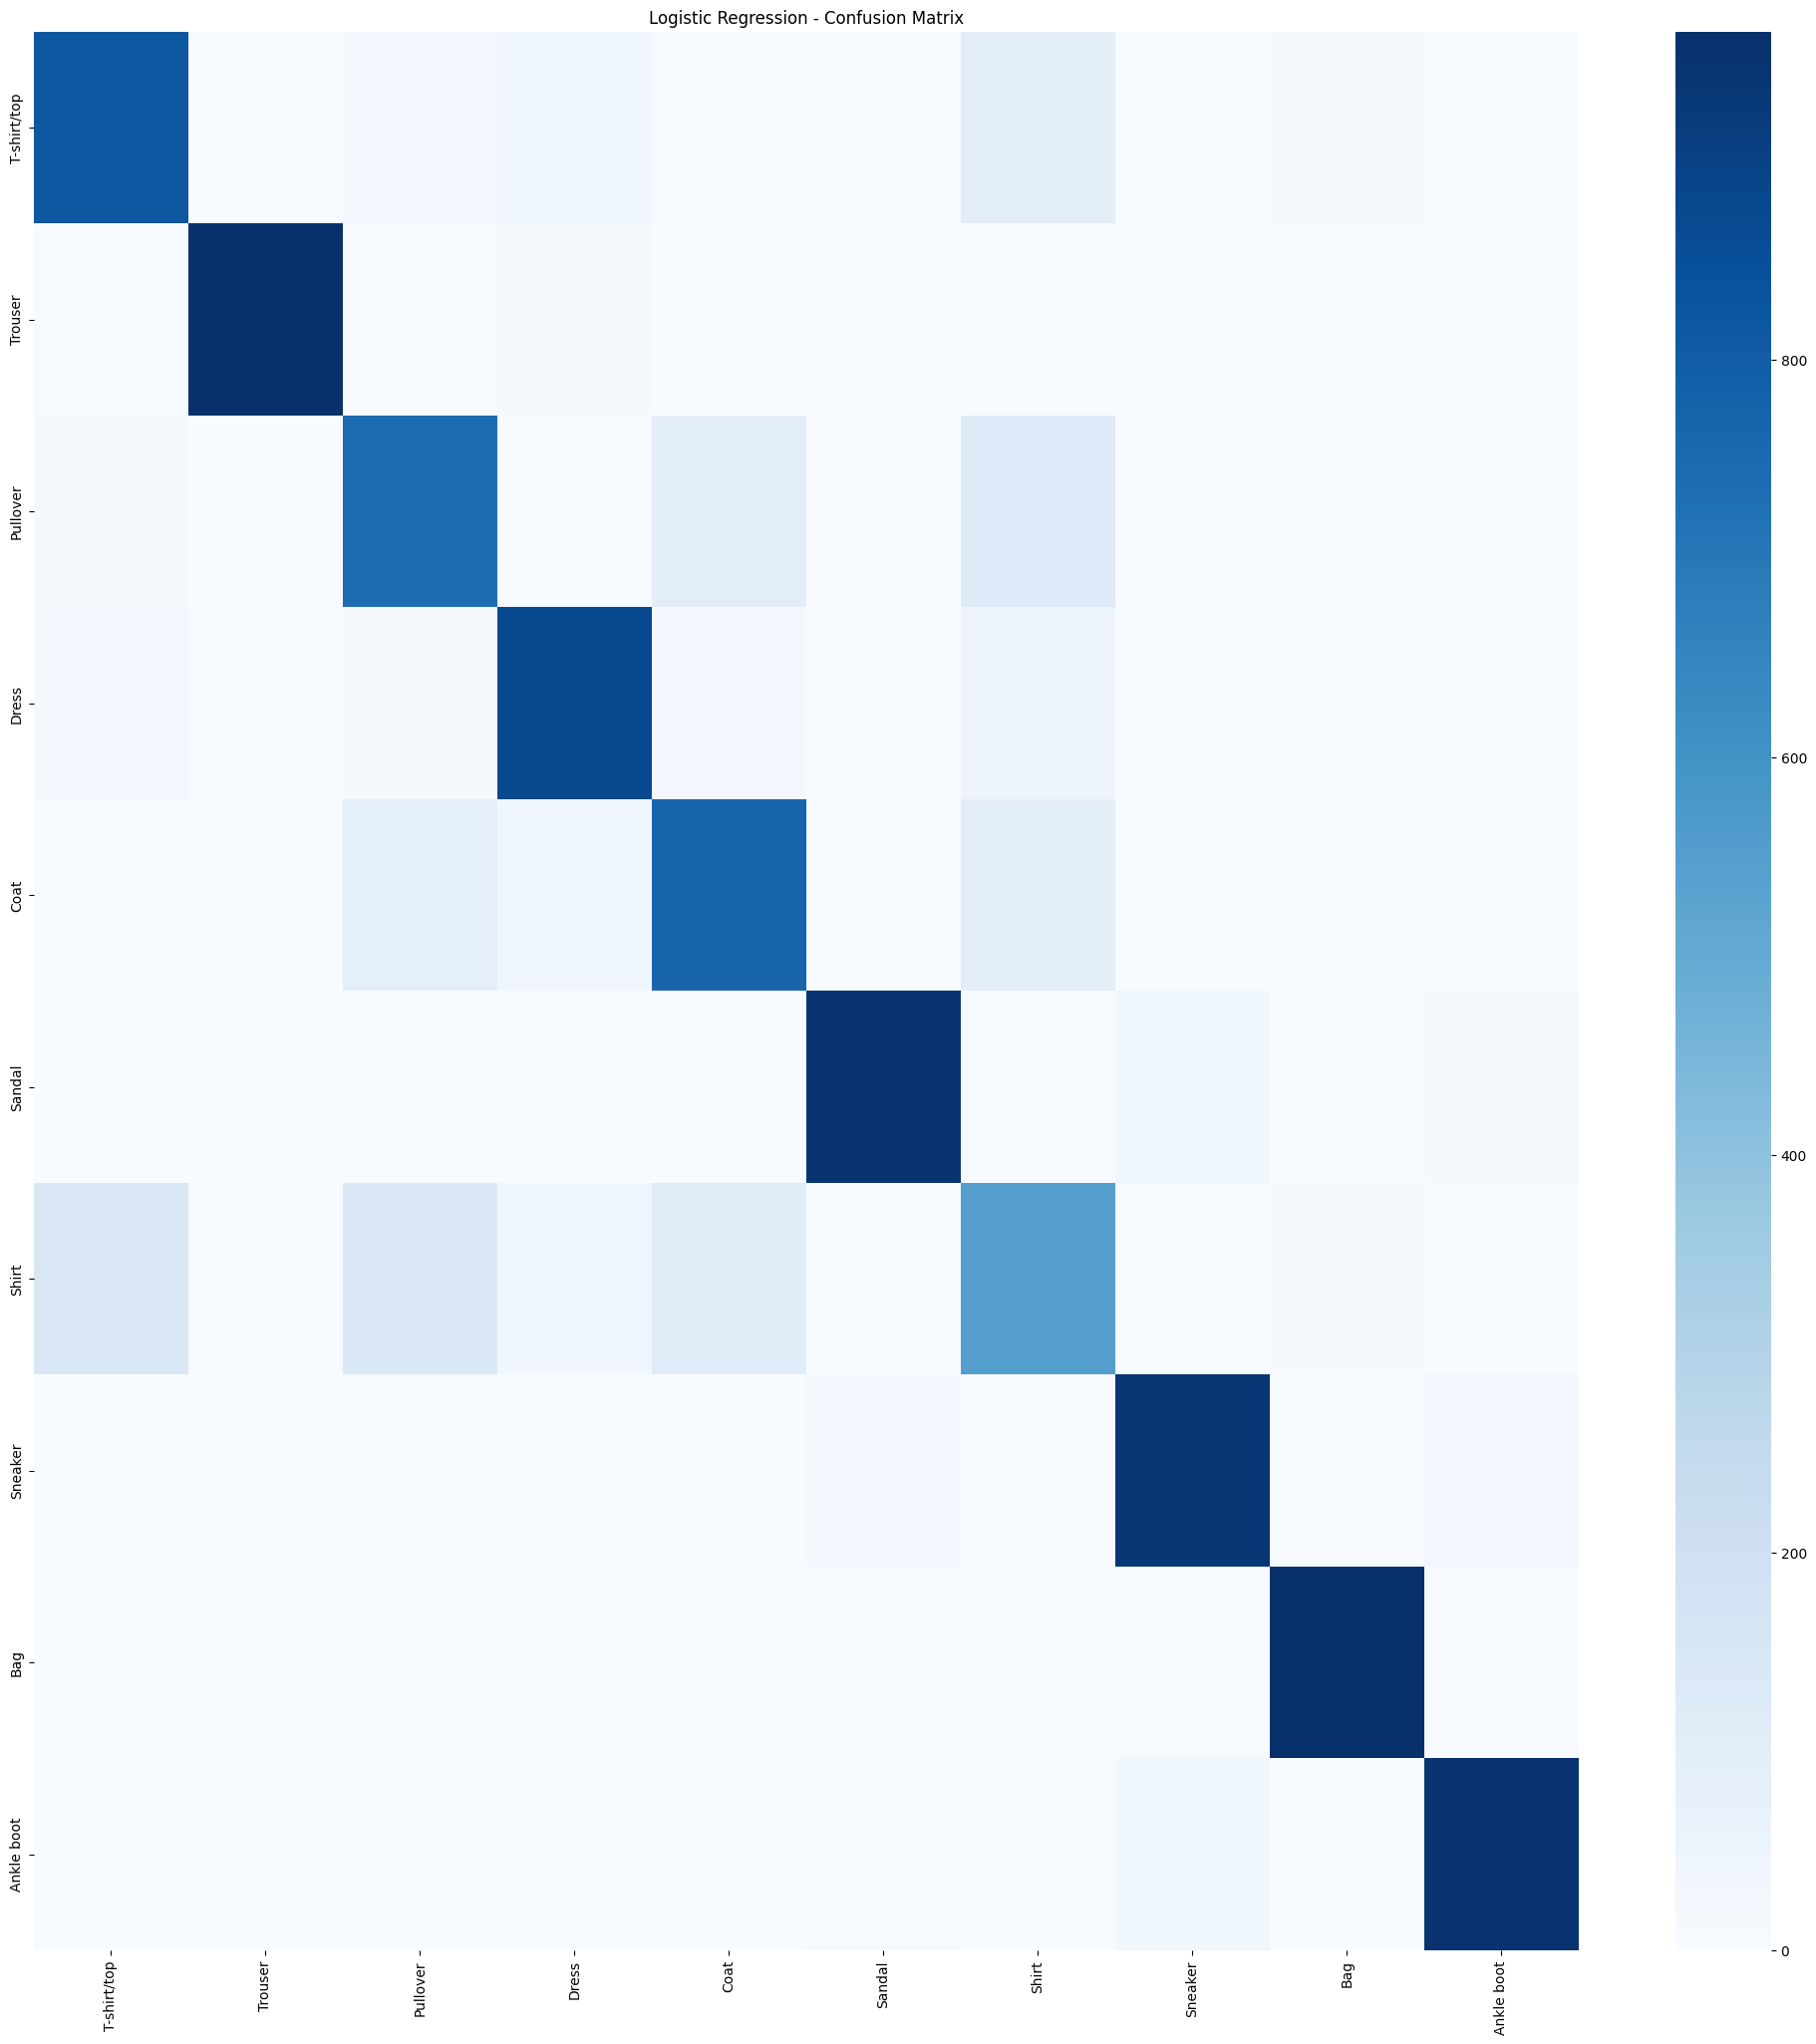

In [ ]:
lr = LogisticRegression(C=10,  max_iter=1000)
lr.fit(reduced_train_features_fashion, y_train)
y_pred_lr = lr.predict(reduced_test_features_fashion)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(25, 25))
sns.heatmap(cm_lr, annot=False, cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=90)
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

Logistic Regression Accuracy: 0.8728565985012067
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       157
           1       0.60      0.66      0.63       164
           2       0.89      0.99      0.94       148
           3       0.95      0.92      0.94       160
           4       0.88      0.91      0.90       164
           5       0.87      0.89      0.88       161
           6       0.94      0.76      0.84       164
           7       0.94      1.00      0.97       234
           8       0.81      0.95      0.87       152
           9       0.81      0.56      0.66       164
          10       0.78      0.59      0.67       164
          11       0.69      0.69      0.69       144
          12       0.95      0.93      0.94       166
          13       0.83      0.99      0.90       164
          14       0.95      0.89      0.92       219
          15       0.89      0.75      0.

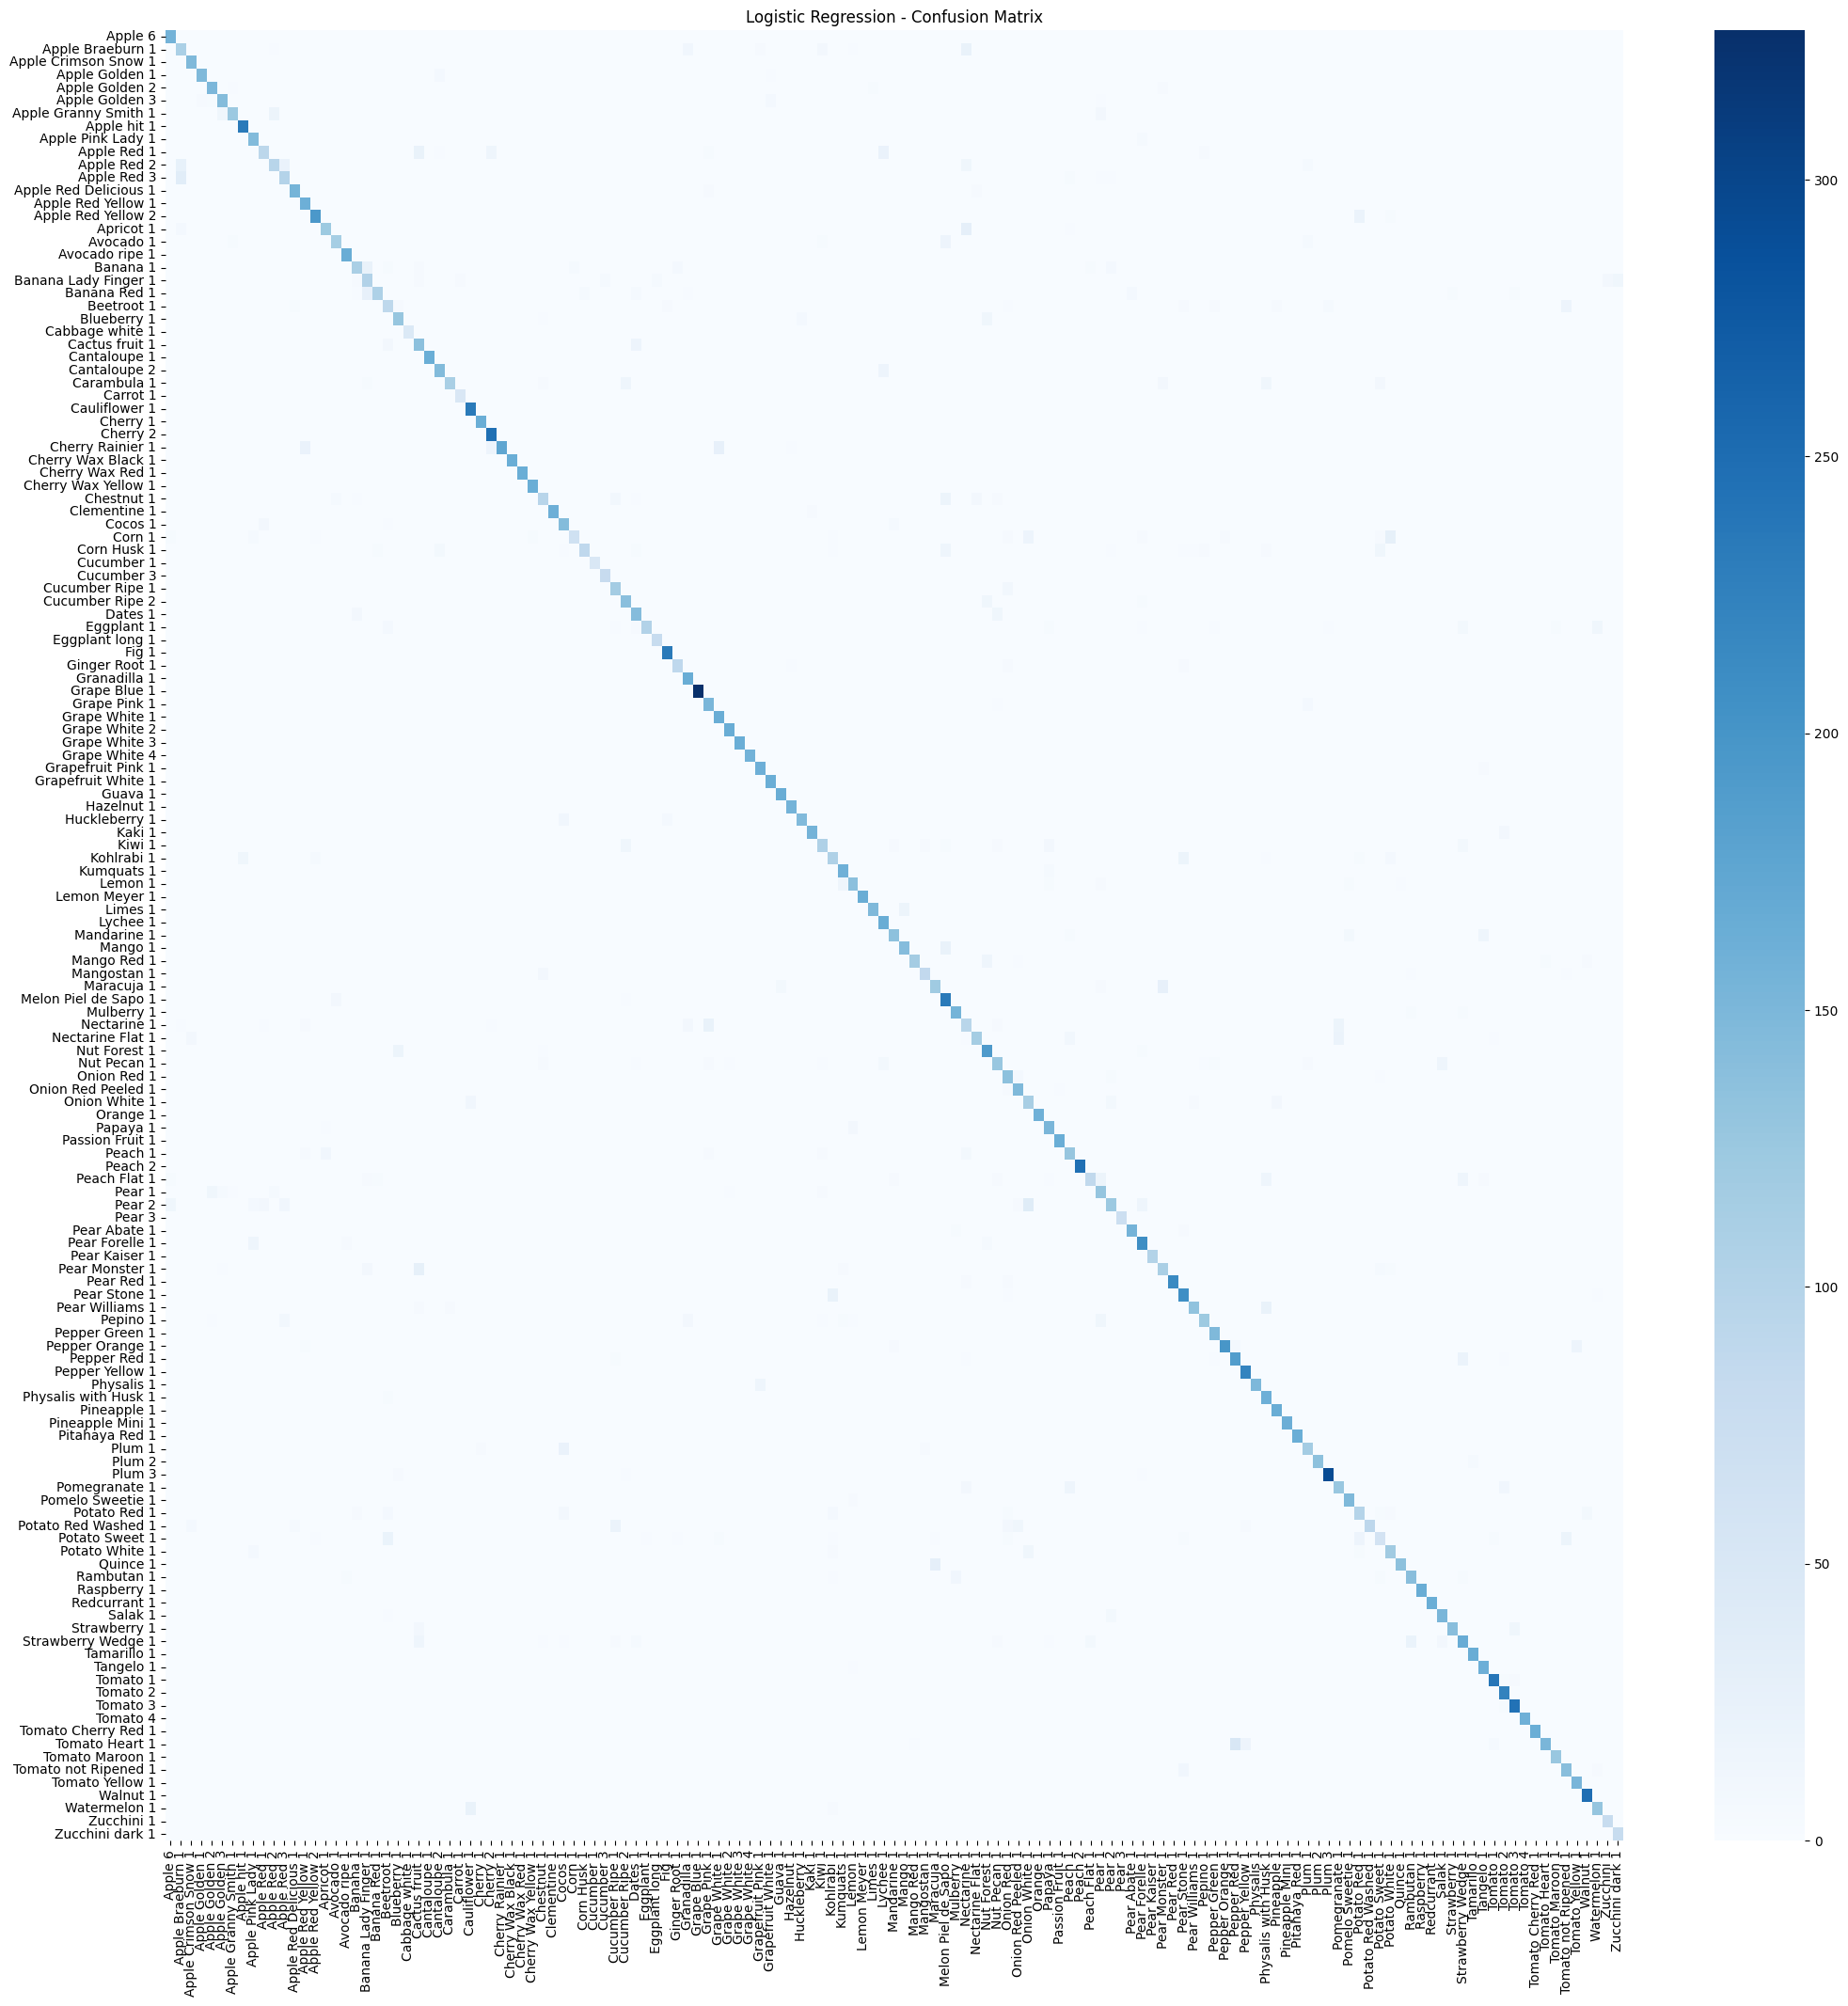

In [23]:
lr = LogisticRegression(max_iter=1000, solver="newton-cg")
lr.fit(reduced_train_features_fruits, y_train_fruits)
y_pred_lr = lr.predict(reduced_test_features_fruits)

class_names = label_map_train.values()

print("Logistic Regression Accuracy:", accuracy_score(y_test_fruits, y_pred_lr))
print("Classification Report (Logistic Regression):")
print(classification_report(y_test_fruits, y_pred_lr))
cm_lr = confusion_matrix(y_test_fruits, y_pred_lr)
plt.figure(figsize=(25, 25))
sns.heatmap(cm_lr, annot=False, cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=90)
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

## SVM

SVM Accuracy: 0.89
Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.82      0.81      1000
           3       0.89      0.90      0.89      1000
           4       0.82      0.82      0.82      1000
           5       0.97      0.96      0.97      1000
           6       0.72      0.69      0.70      1000
           7       0.94      0.96      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



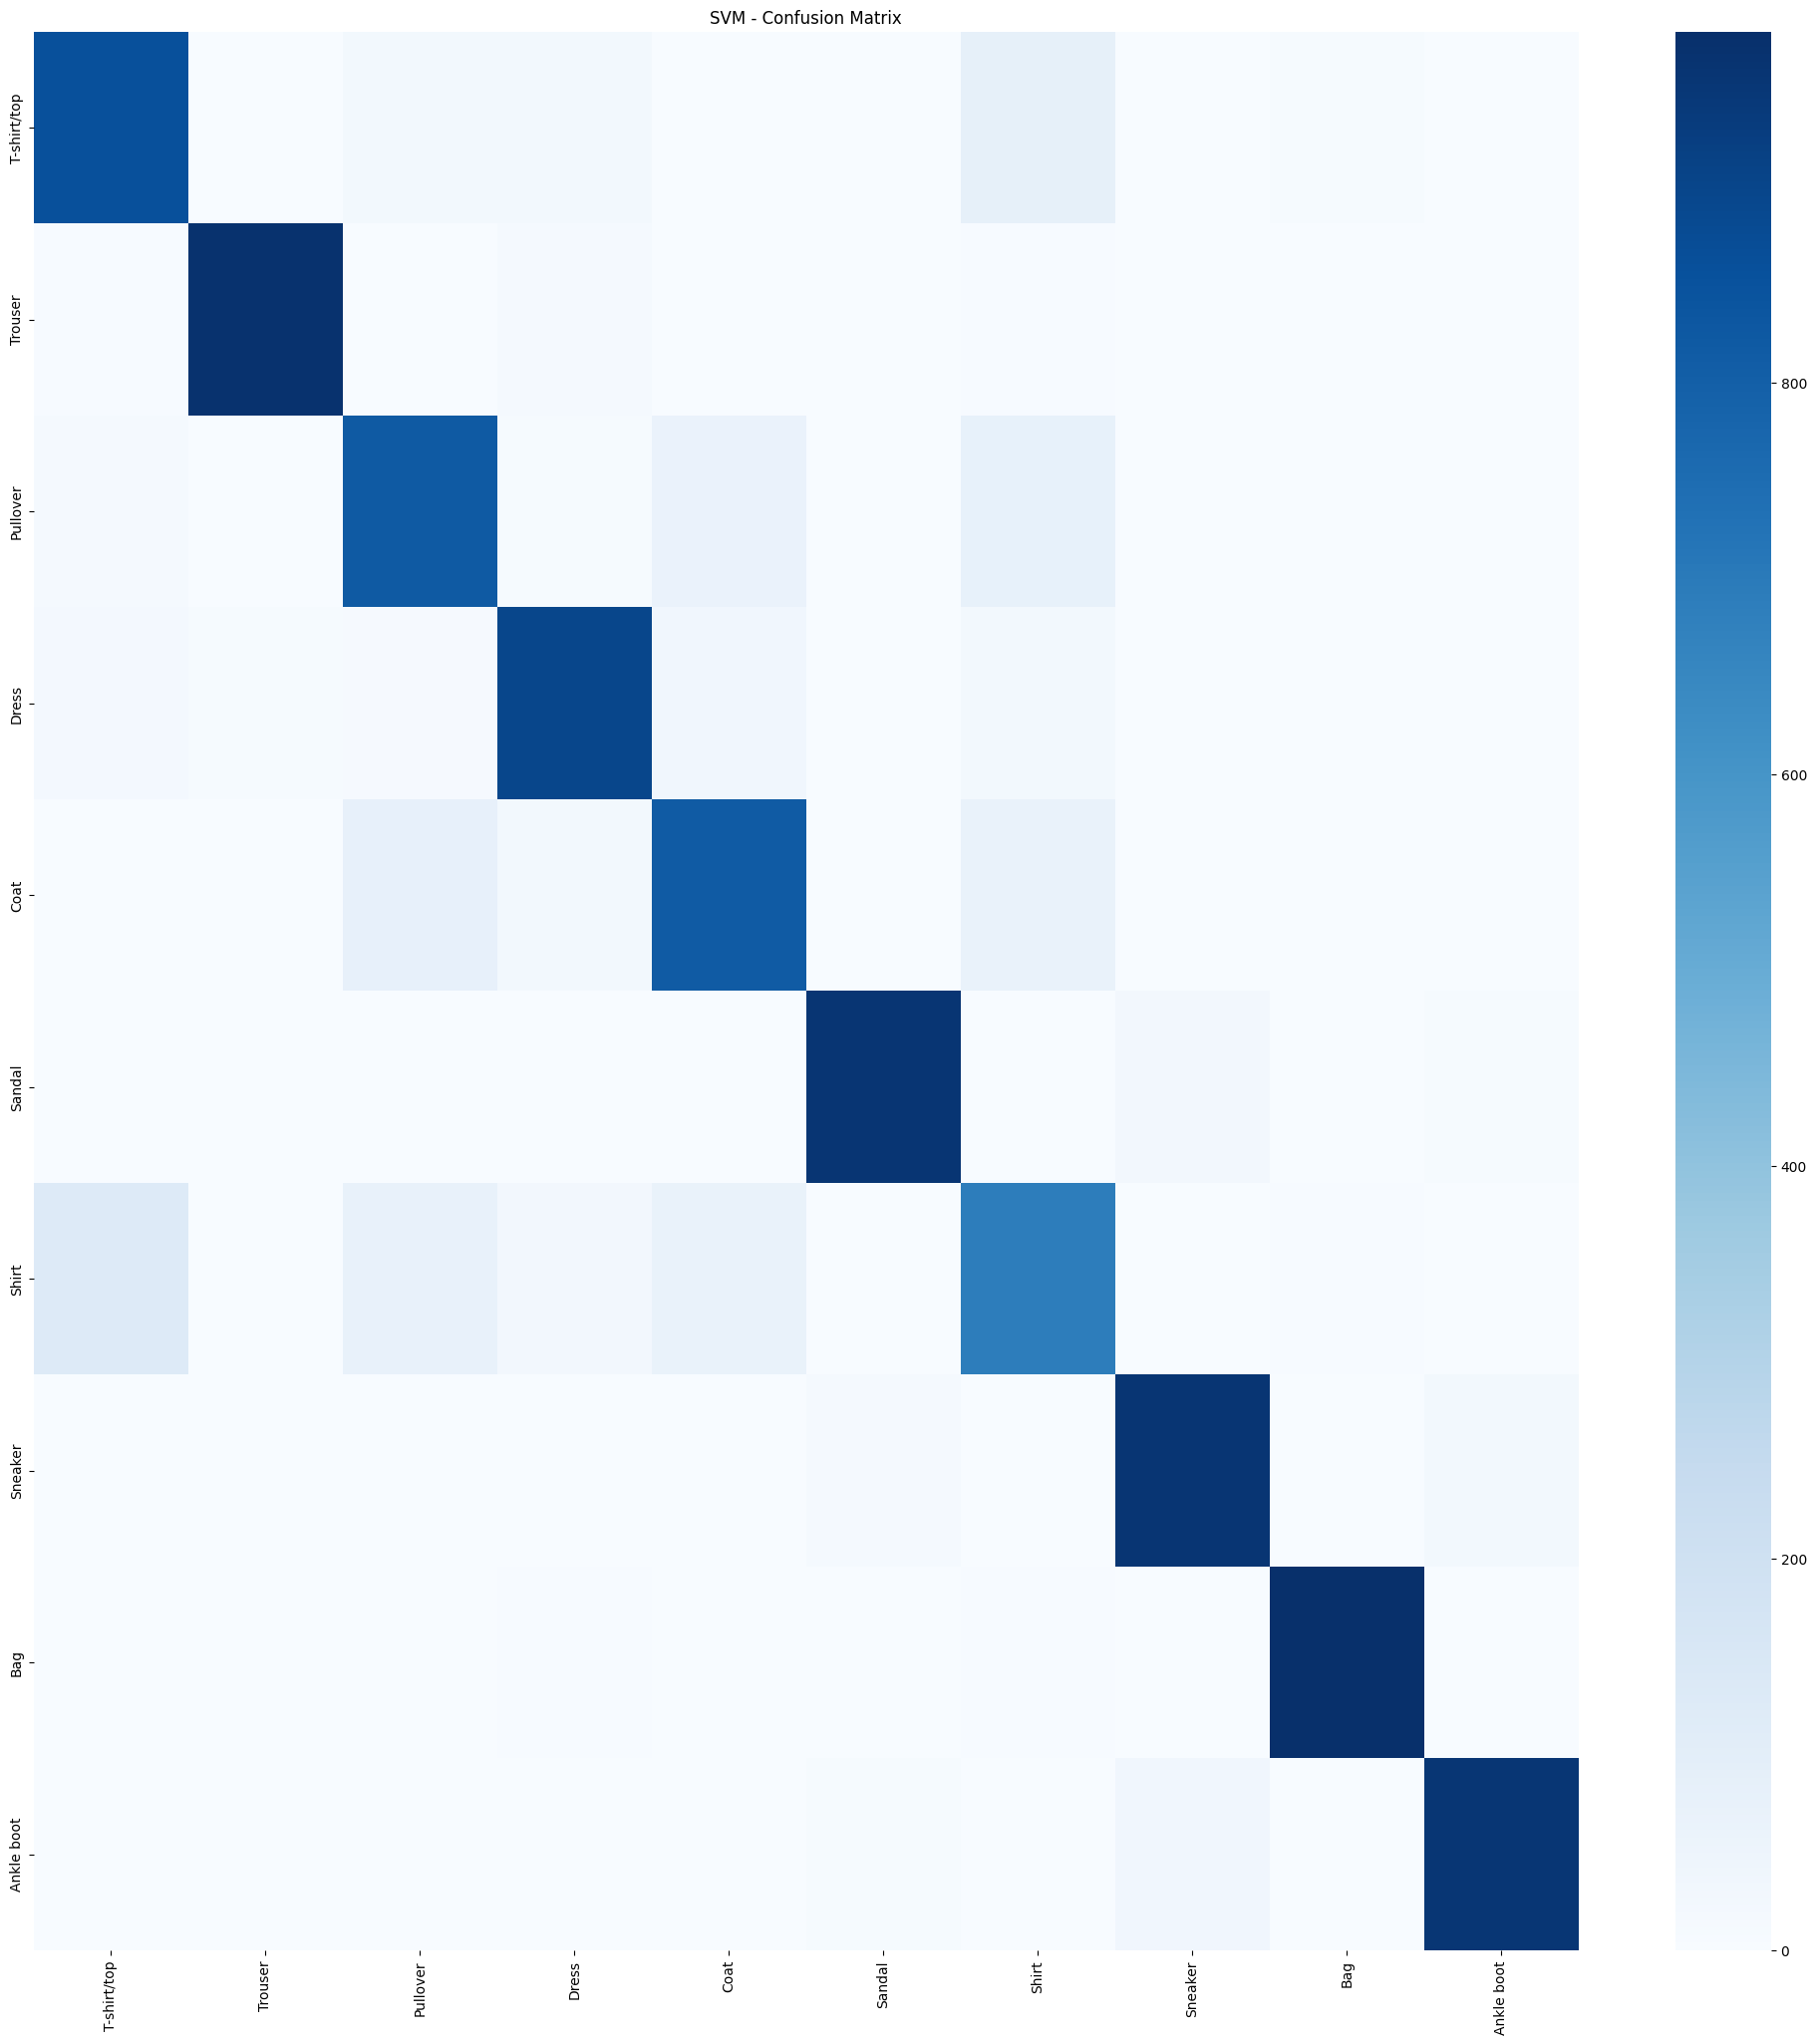

In [19]:
svm = SVC(C=10, gamma='auto', kernel='rbf')
svm.fit(reduced_train_features_fashion, y_train)
y_pred_svm = svm.predict(reduced_test_features_fashion)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(25, 25))
sns.heatmap(cm_svm, annot=False, cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=90)
plt.title('SVM - Confusion Matrix')
plt.show()

SVM Regression Accuracy: 0.9156187814894788
Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       157
           1       0.61      0.66      0.63       164
           2       0.93      1.00      0.96       148
           3       0.93      0.98      0.96       160
           4       0.89      0.90      0.90       164
           5       0.71      0.90      0.80       161
           6       0.89      0.82      0.85       164
           7       1.00      1.00      1.00       234
           8       0.76      0.97      0.85       152
           9       0.80      0.65      0.72       164
          10       0.86      0.72      0.78       164
          11       0.91      0.83      0.87       144
          12       0.92      0.94      0.93       166
          13       0.81      0.99      0.89       164
          14       1.00      0.99      0.99       219
          15       0.99      0.95      0.97       164
        

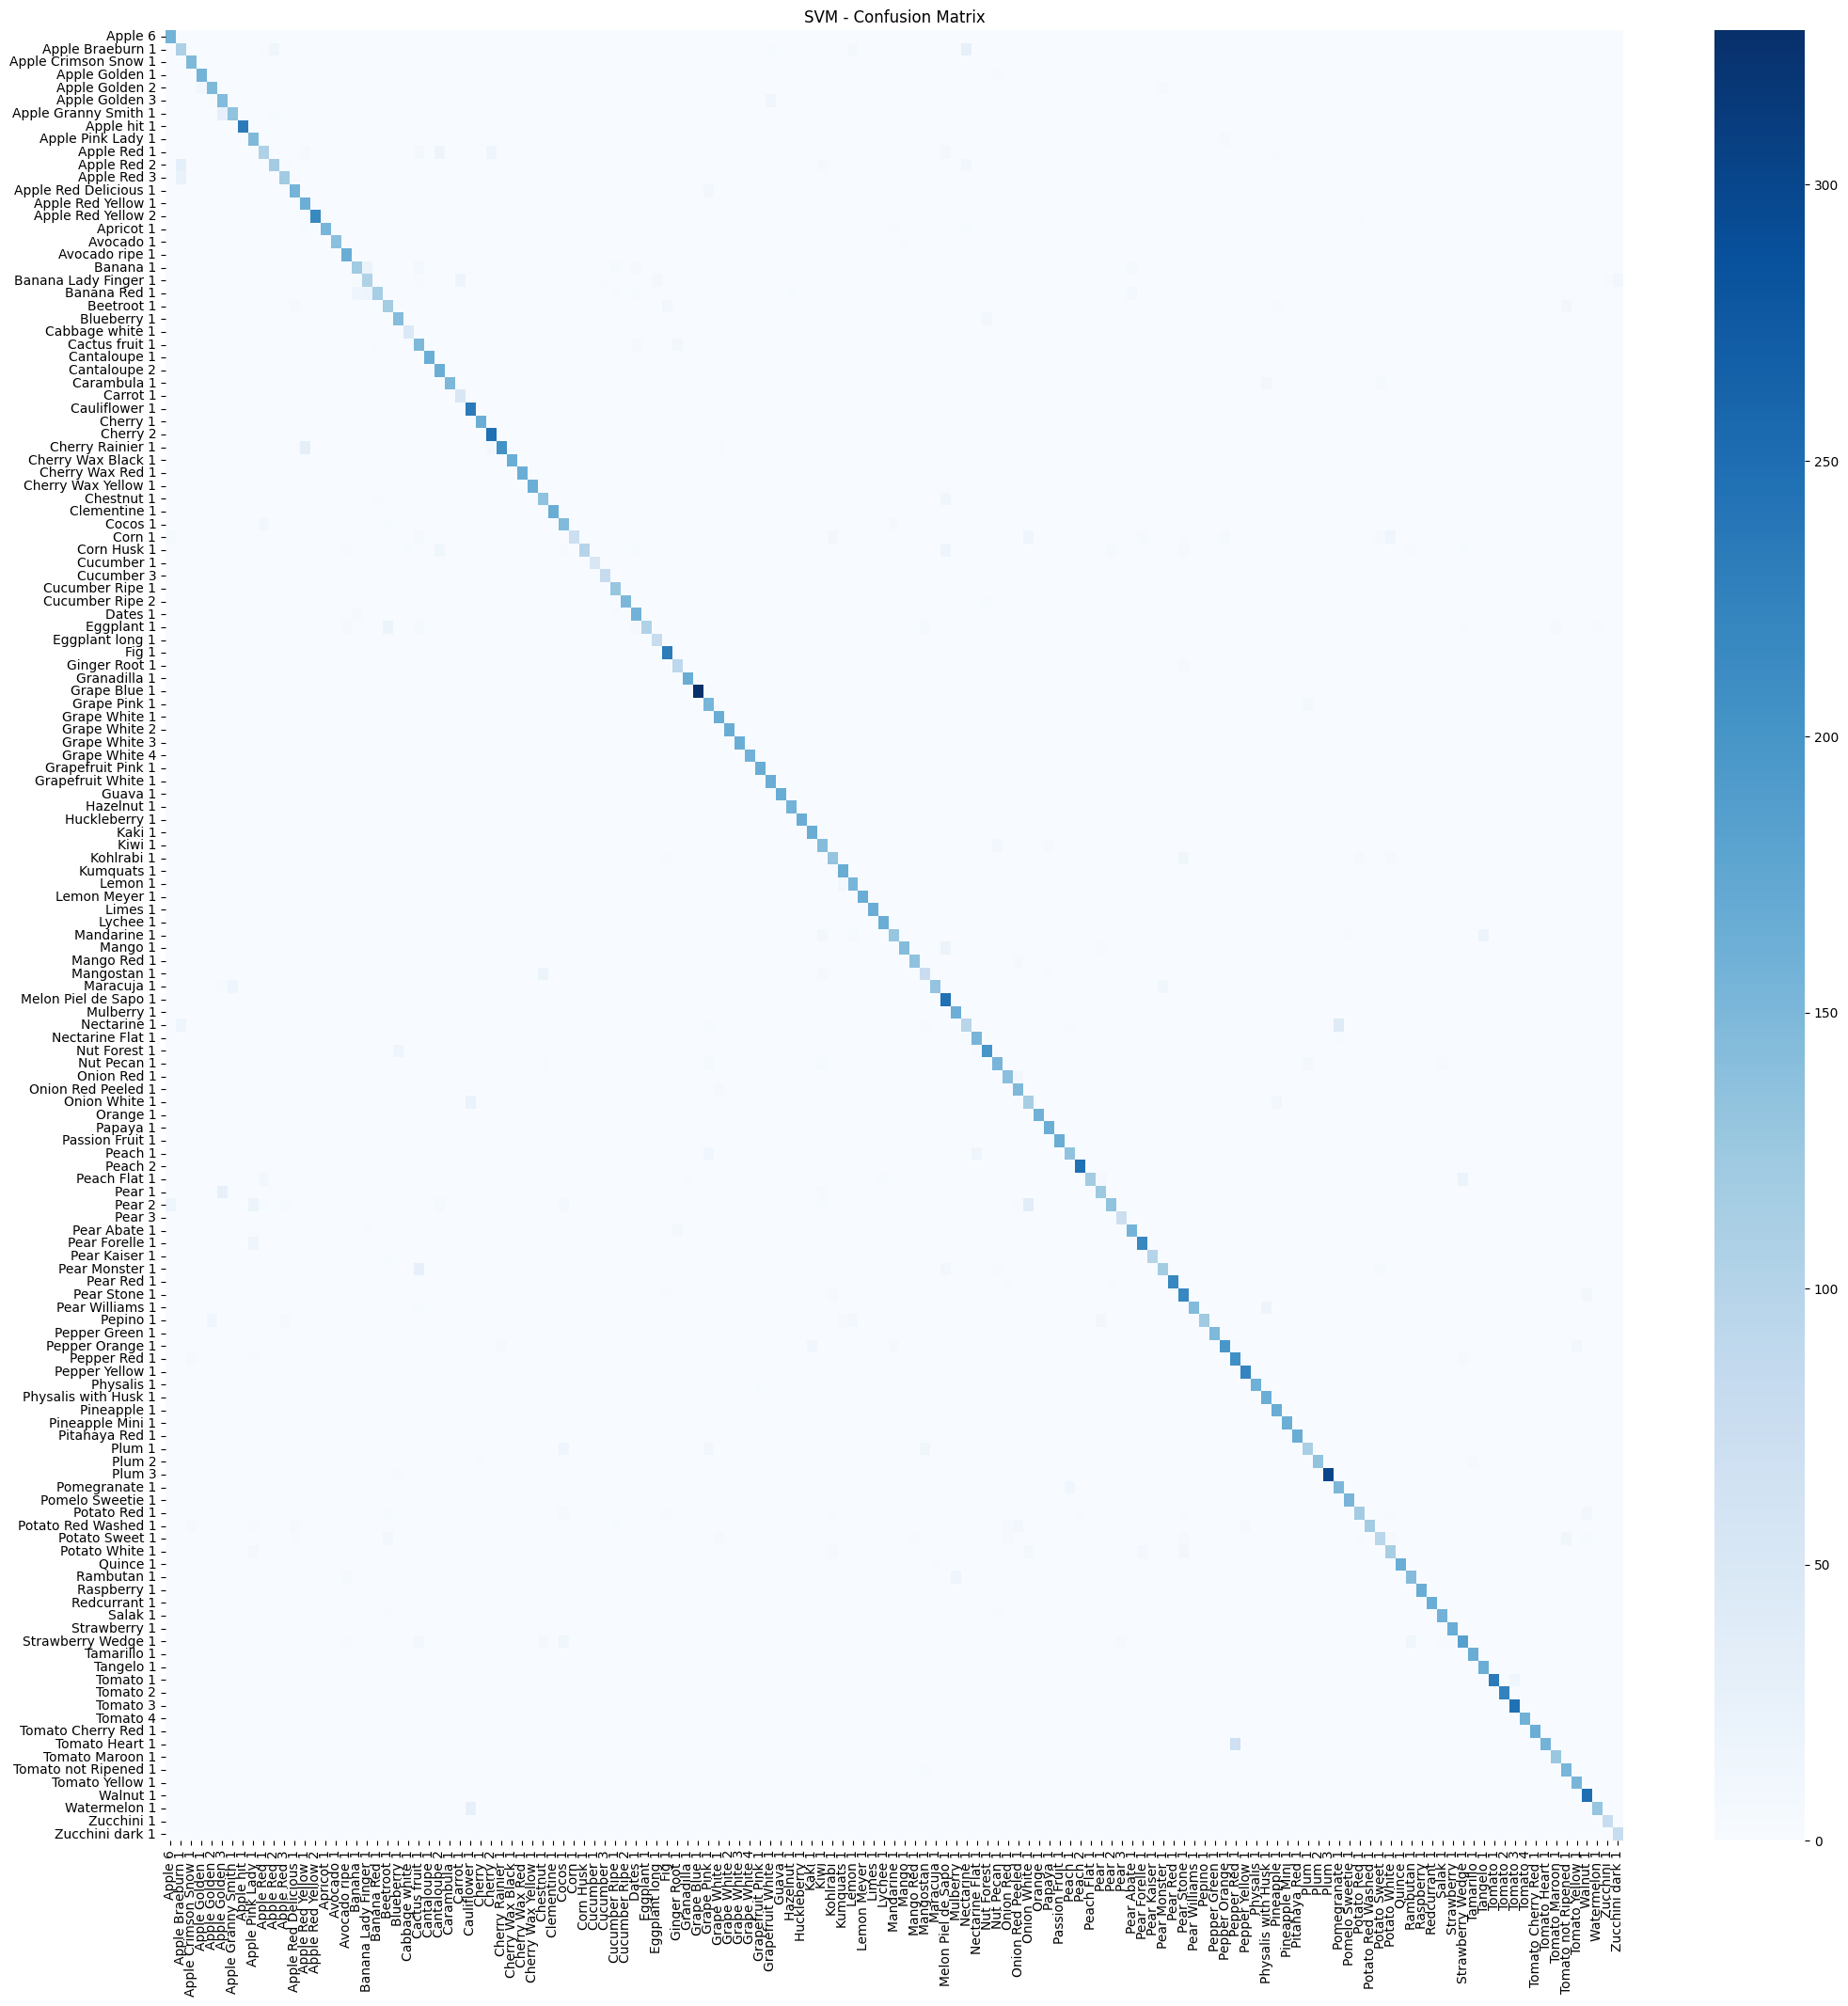

In [23]:
svm = SVC(C=1, gamma='scale', kernel='linear')
svm.fit(reduced_train_features_fruits, y_train_fruits)
y_pred_svm = svm.predict(reduced_test_features_fruits)

class_names = label_map_train.values()

print("SVM Regression Accuracy:", accuracy_score(y_test_fruits, y_pred_svm))
print("Classification Report (SVM):")
print(classification_report(y_test_fruits, y_pred_svm))
cm_svm = confusion_matrix(y_test_fruits, y_pred_svm)
plt.figure(figsize=(25, 25))
sns.heatmap(cm_svm, annot=False, cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=90)
plt.title('SVM - Confusion Matrix')
plt.show()

## Random Forest

RF Accuracy: 0.8586
Classification Report (RF):
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1000
           1       0.99      0.95      0.97      1000
           2       0.77      0.78      0.77      1000
           3       0.86      0.89      0.87      1000
           4       0.74      0.79      0.76      1000
           5       0.94      0.94      0.94      1000
           6       0.67      0.55      0.61      1000
           7       0.91      0.92      0.92      1000
           8       0.94      0.97      0.96      1000
           9       0.94      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



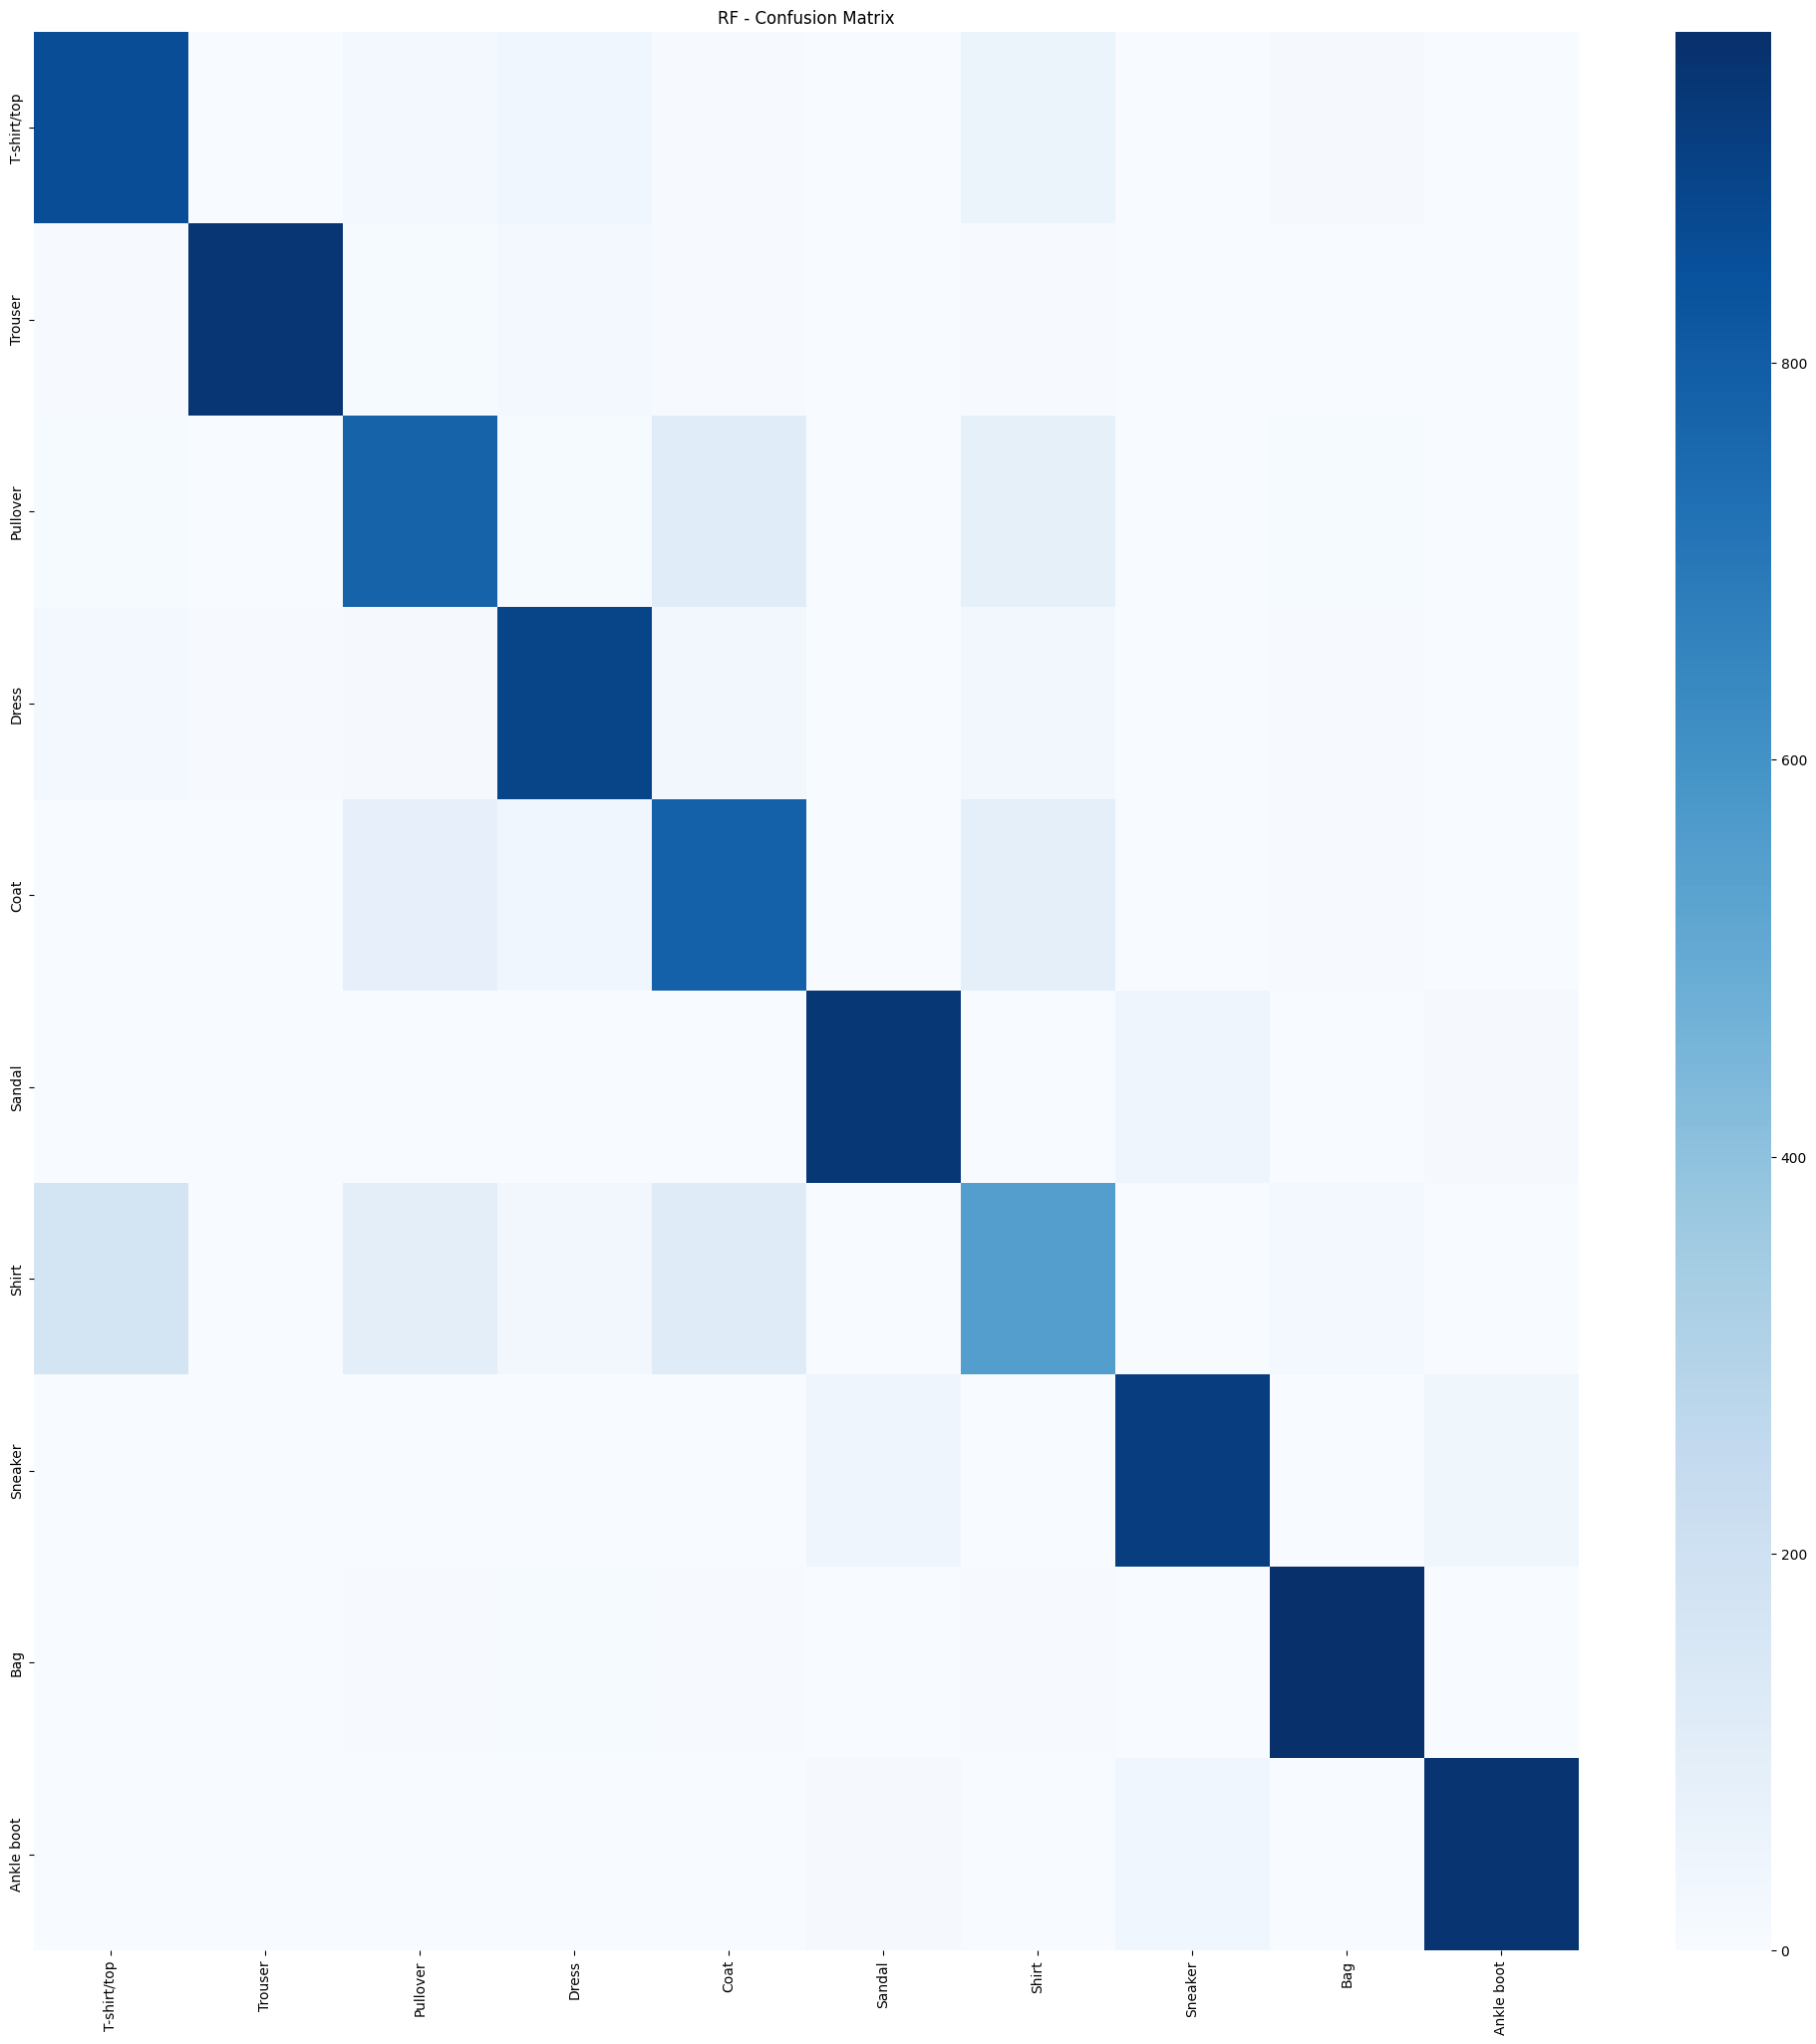

In [ ]:
rf = RandomForestClassifier(n_estimators=500, min_samples_split=5, criterion='entropy')
rf.fit(reduced_train_features_fashion, y_train)

y_pred_rf = rf.predict(reduced_test_features_fashion)
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report (RF):")
print(classification_report(y_test, y_pred_rf))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(25, 25))
sns.heatmap(cm_rf, annot=False, cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=90)
plt.title('RF - Confusion Matrix')
plt.show()

RF Accuracy: 0.8952961598712901
Classification Report (RF):
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       157
           1       0.73      0.68      0.70       164
           2       0.71      0.67      0.69       148
           3       0.88      0.93      0.90       160
           4       0.83      0.90      0.86       164
           5       0.71      0.97      0.82       161
           6       0.90      0.87      0.88       164
           7       0.95      1.00      0.97       234
           8       0.68      0.79      0.73       152
           9       0.95      0.98      0.96       164
          10       0.90      0.82      0.86       164
          11       0.78      0.81      0.80       144
          12       1.00      1.00      1.00       166
          13       0.96      0.98      0.97       164
          14       0.91      1.00      0.95       219
          15       0.97      0.85      0.91       164
          16       0.

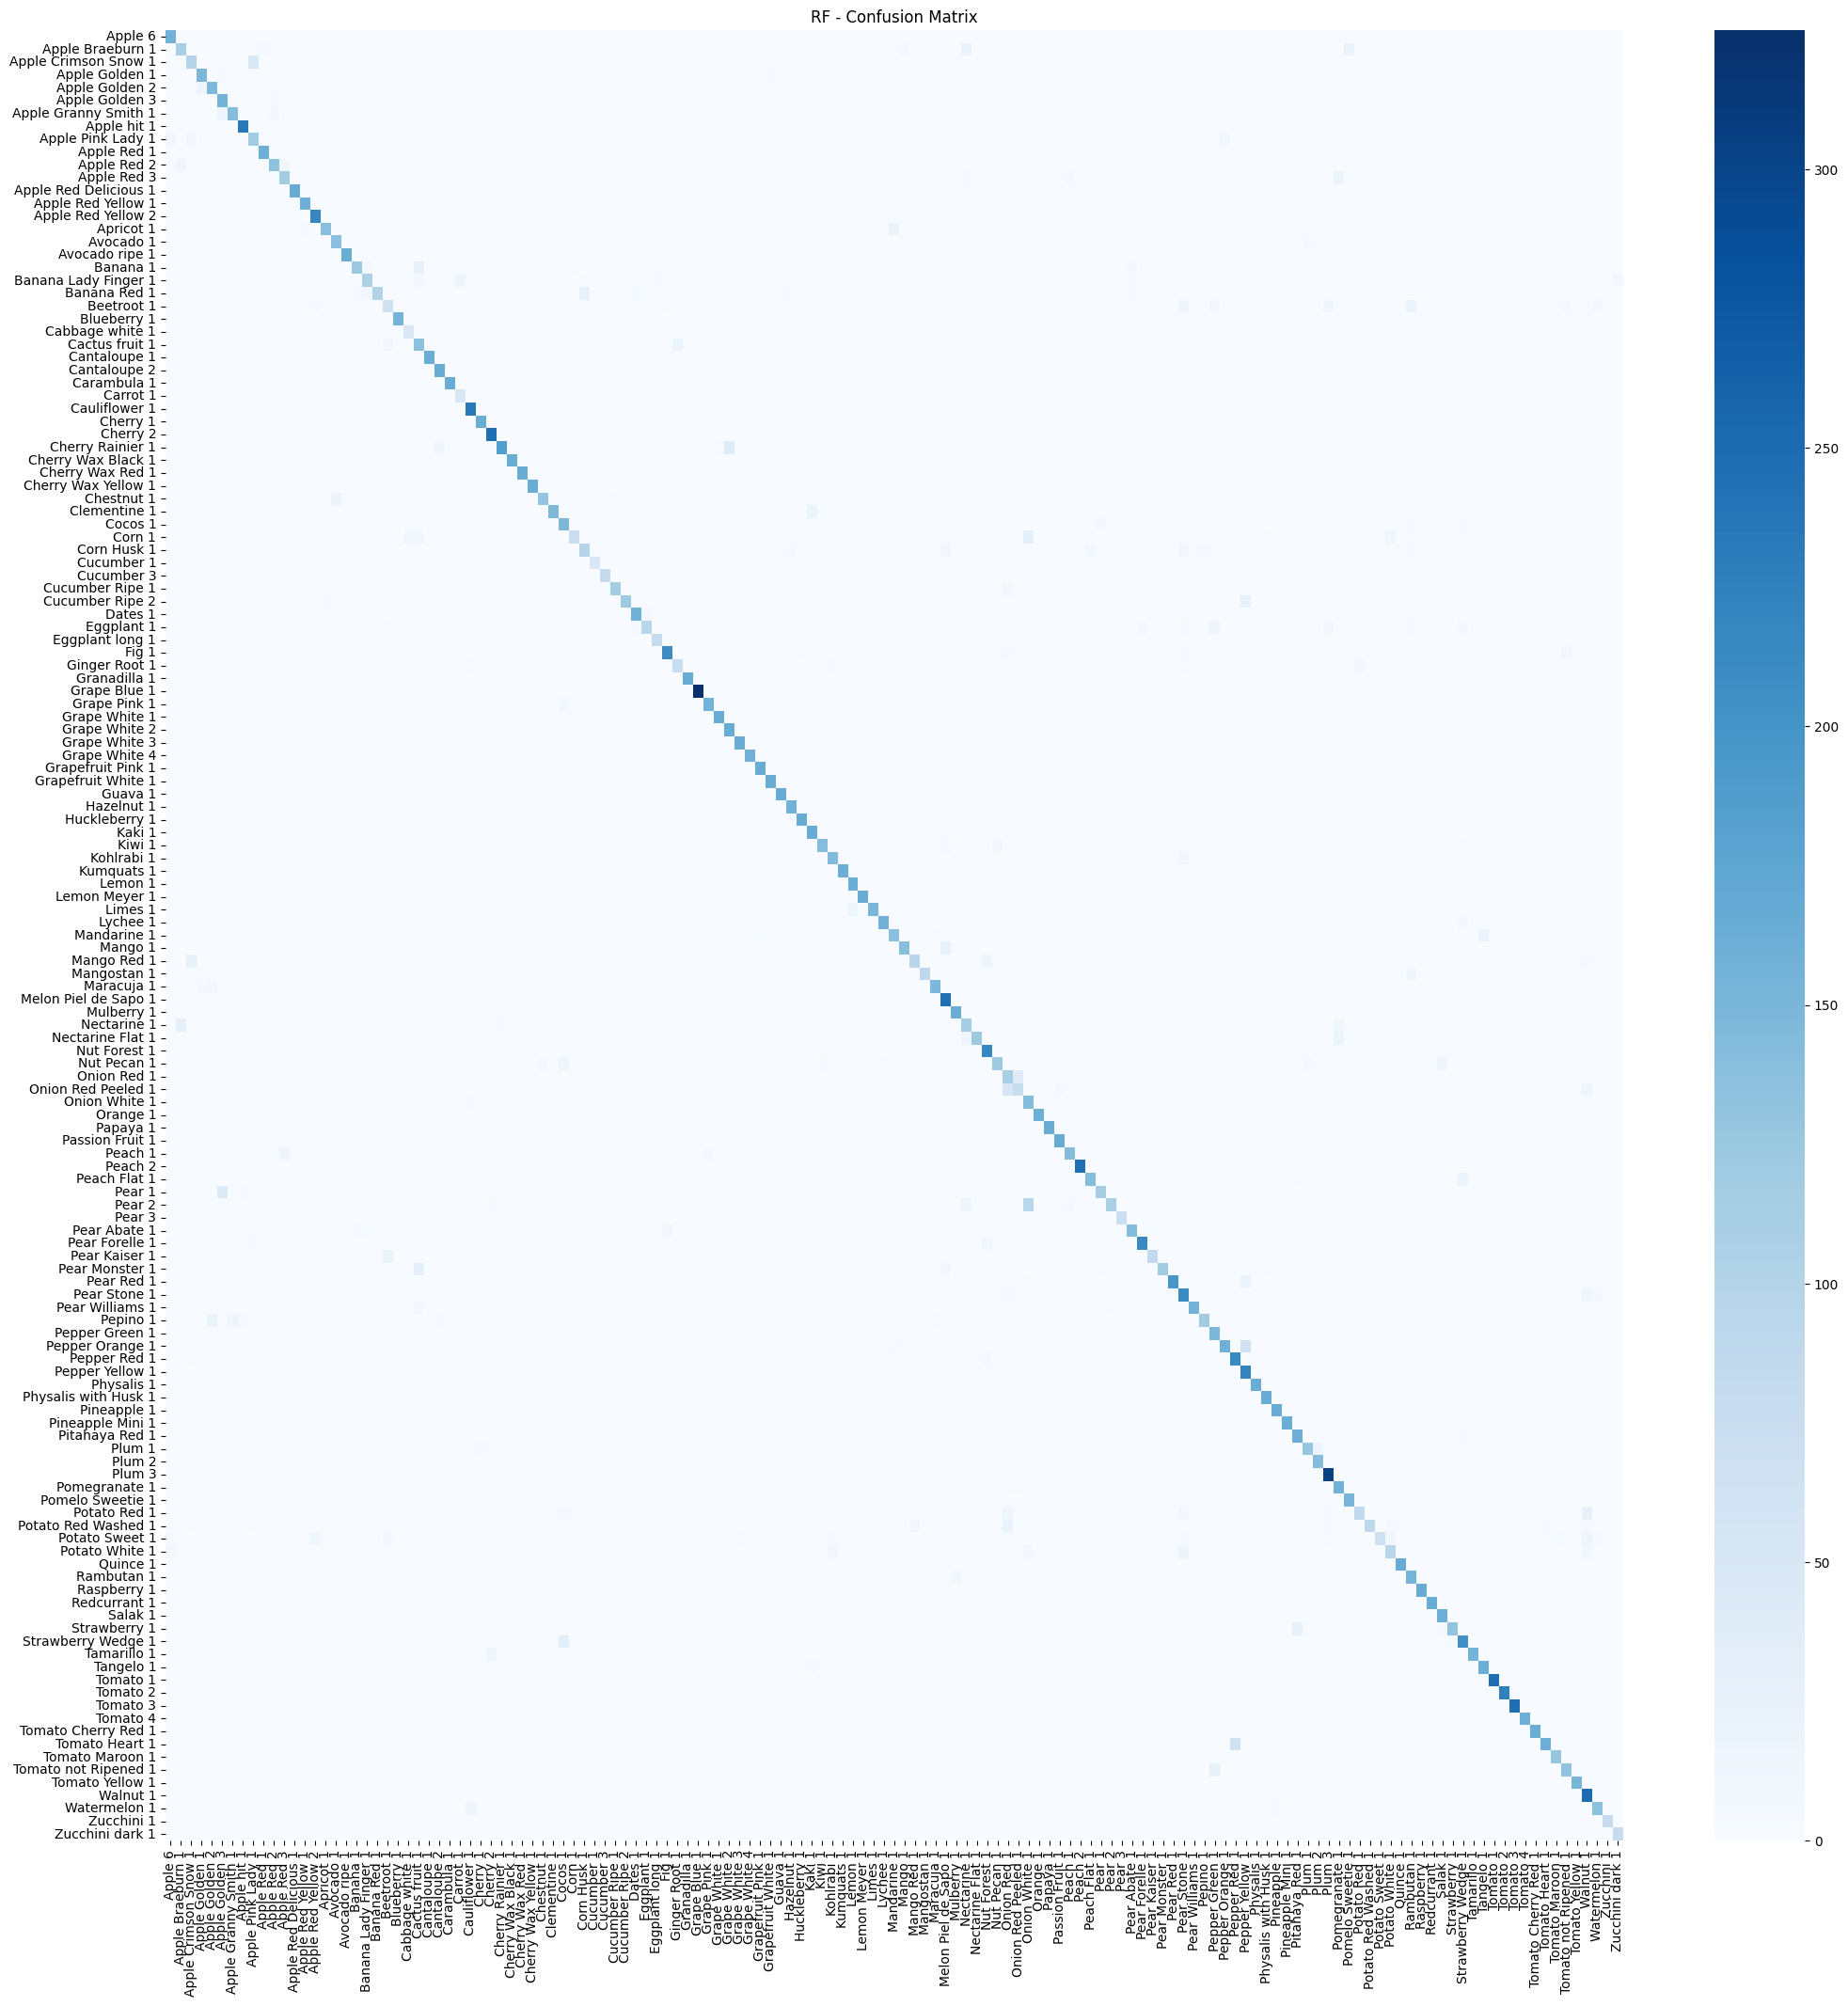

In [ ]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=5, criterion='log_loss', max_depth=30)
rf.fit(reduced_train_features_fruits, y_train_fruits)

y_pred_rf = rf.predict(reduced_test_features_fruits)
print("RF Accuracy:", accuracy_score(y_test_fruits, y_pred_rf))
print("Classification Report (RF):")
print(classification_report(y_test_fruits, y_pred_rf))

class_names = label_map_train.values()

cm_rf = confusion_matrix(y_test_fruits, y_pred_rf)
plt.figure(figsize=(25, 25))
sns.heatmap(cm_rf, annot=False, cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=90)
plt.title('RF - Confusion Matrix')
plt.show()

## XGBoost

XGBoost Accuracy: 0.8853
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.81      0.81      1000
           3       0.89      0.89      0.89      1000
           4       0.79      0.83      0.81      1000
           5       0.97      0.96      0.97      1000
           6       0.69      0.64      0.67      1000
           7       0.94      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.88     10000
weighted avg       0.89      0.89      0.88     10000



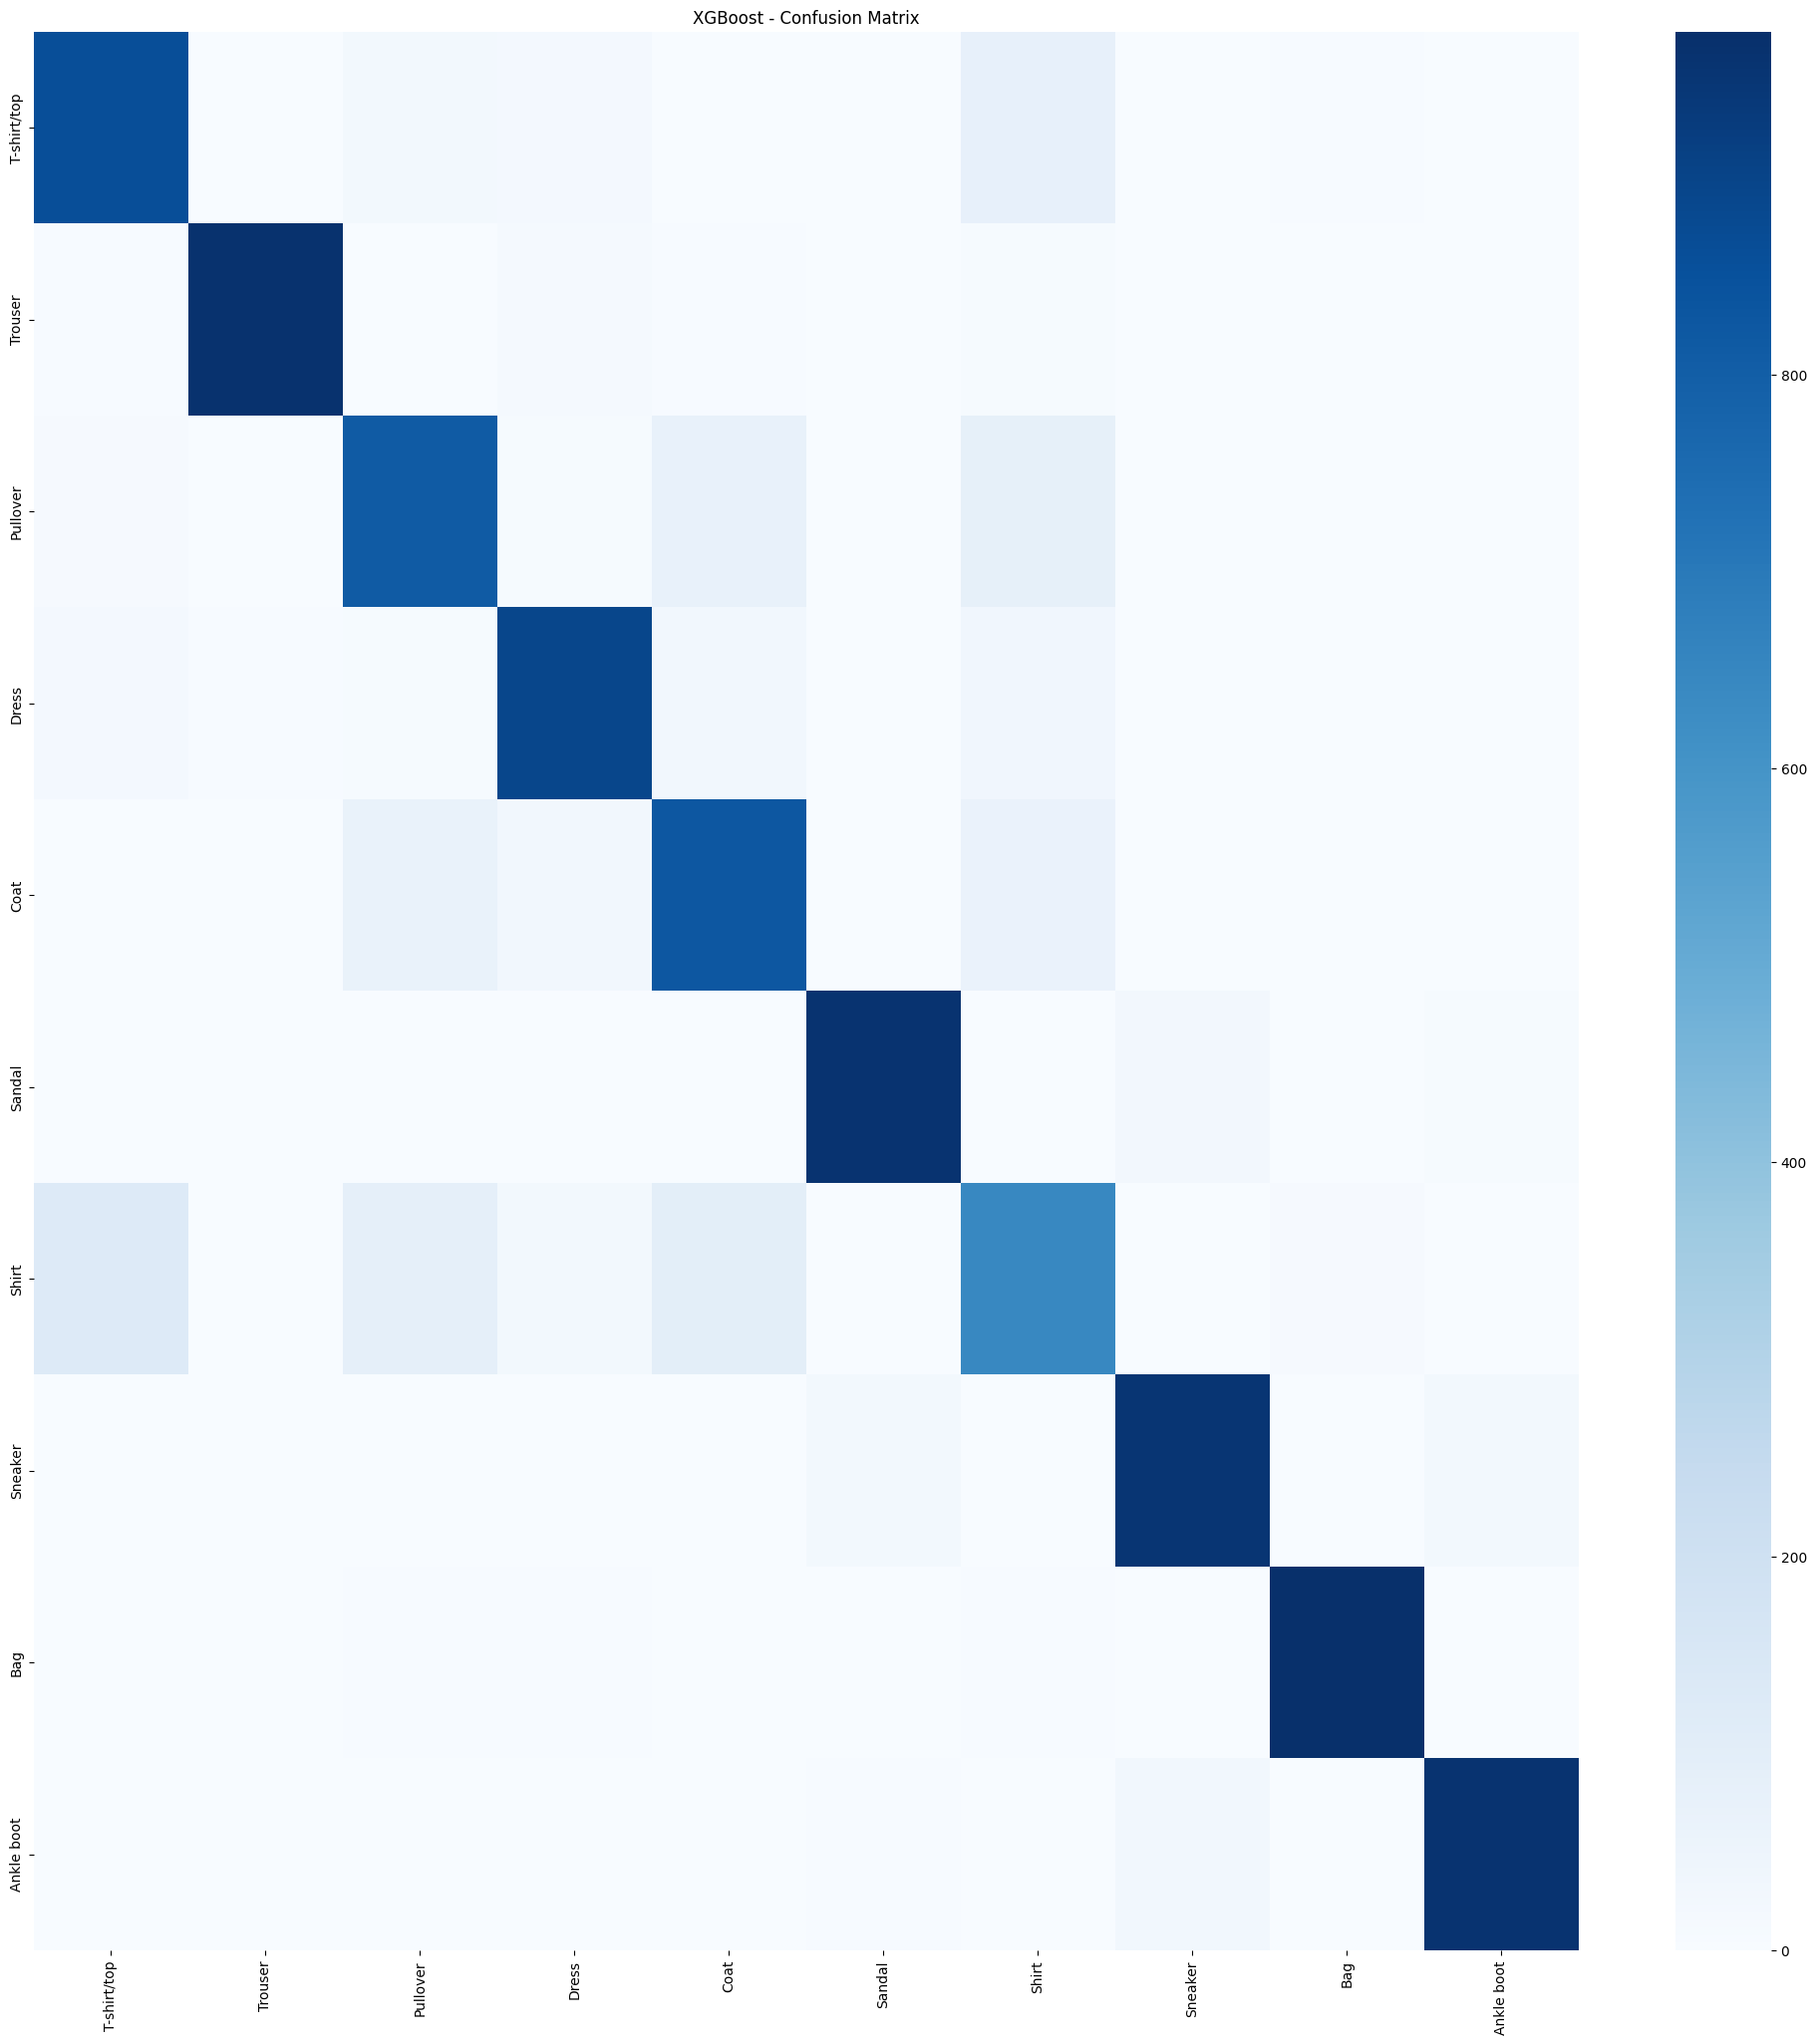

In [ ]:
xgb = XGBClassifier(n_estimators=400, max_depth=4, learning_rate=0.1, subsample=0.9, colsample_bytree=0.8)
xgb.fit(reduced_train_features_fashion, y_train)

y_pred_xgb = xgb.predict(reduced_test_features_fashion)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
			   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(25, 25))
sns.heatmap(cm_xgb, annot=False, cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=90)
plt.title('XGBoost - Confusion Matrix')
plt.show()

XGBoost Accuracy: 0.8602396375799145
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       157
           1       0.58      0.66      0.62       164
           2       0.74      0.64      0.69       148
           3       0.89      0.74      0.81       160
           4       0.85      0.90      0.88       164
           5       0.79      1.00      0.88       161
           6       0.98      0.74      0.85       164
           7       0.88      1.00      0.94       234
           8       0.62      0.98      0.76       152
           9       0.94      0.93      0.93       164
          10       0.77      0.74      0.75       164
          11       0.58      0.45      0.51       144
          12       0.96      0.98      0.97       166
          13       0.75      0.71      0.73       164
          14       0.91      0.92      0.91       219
          15       0.84      0.73      0.78       164
          1

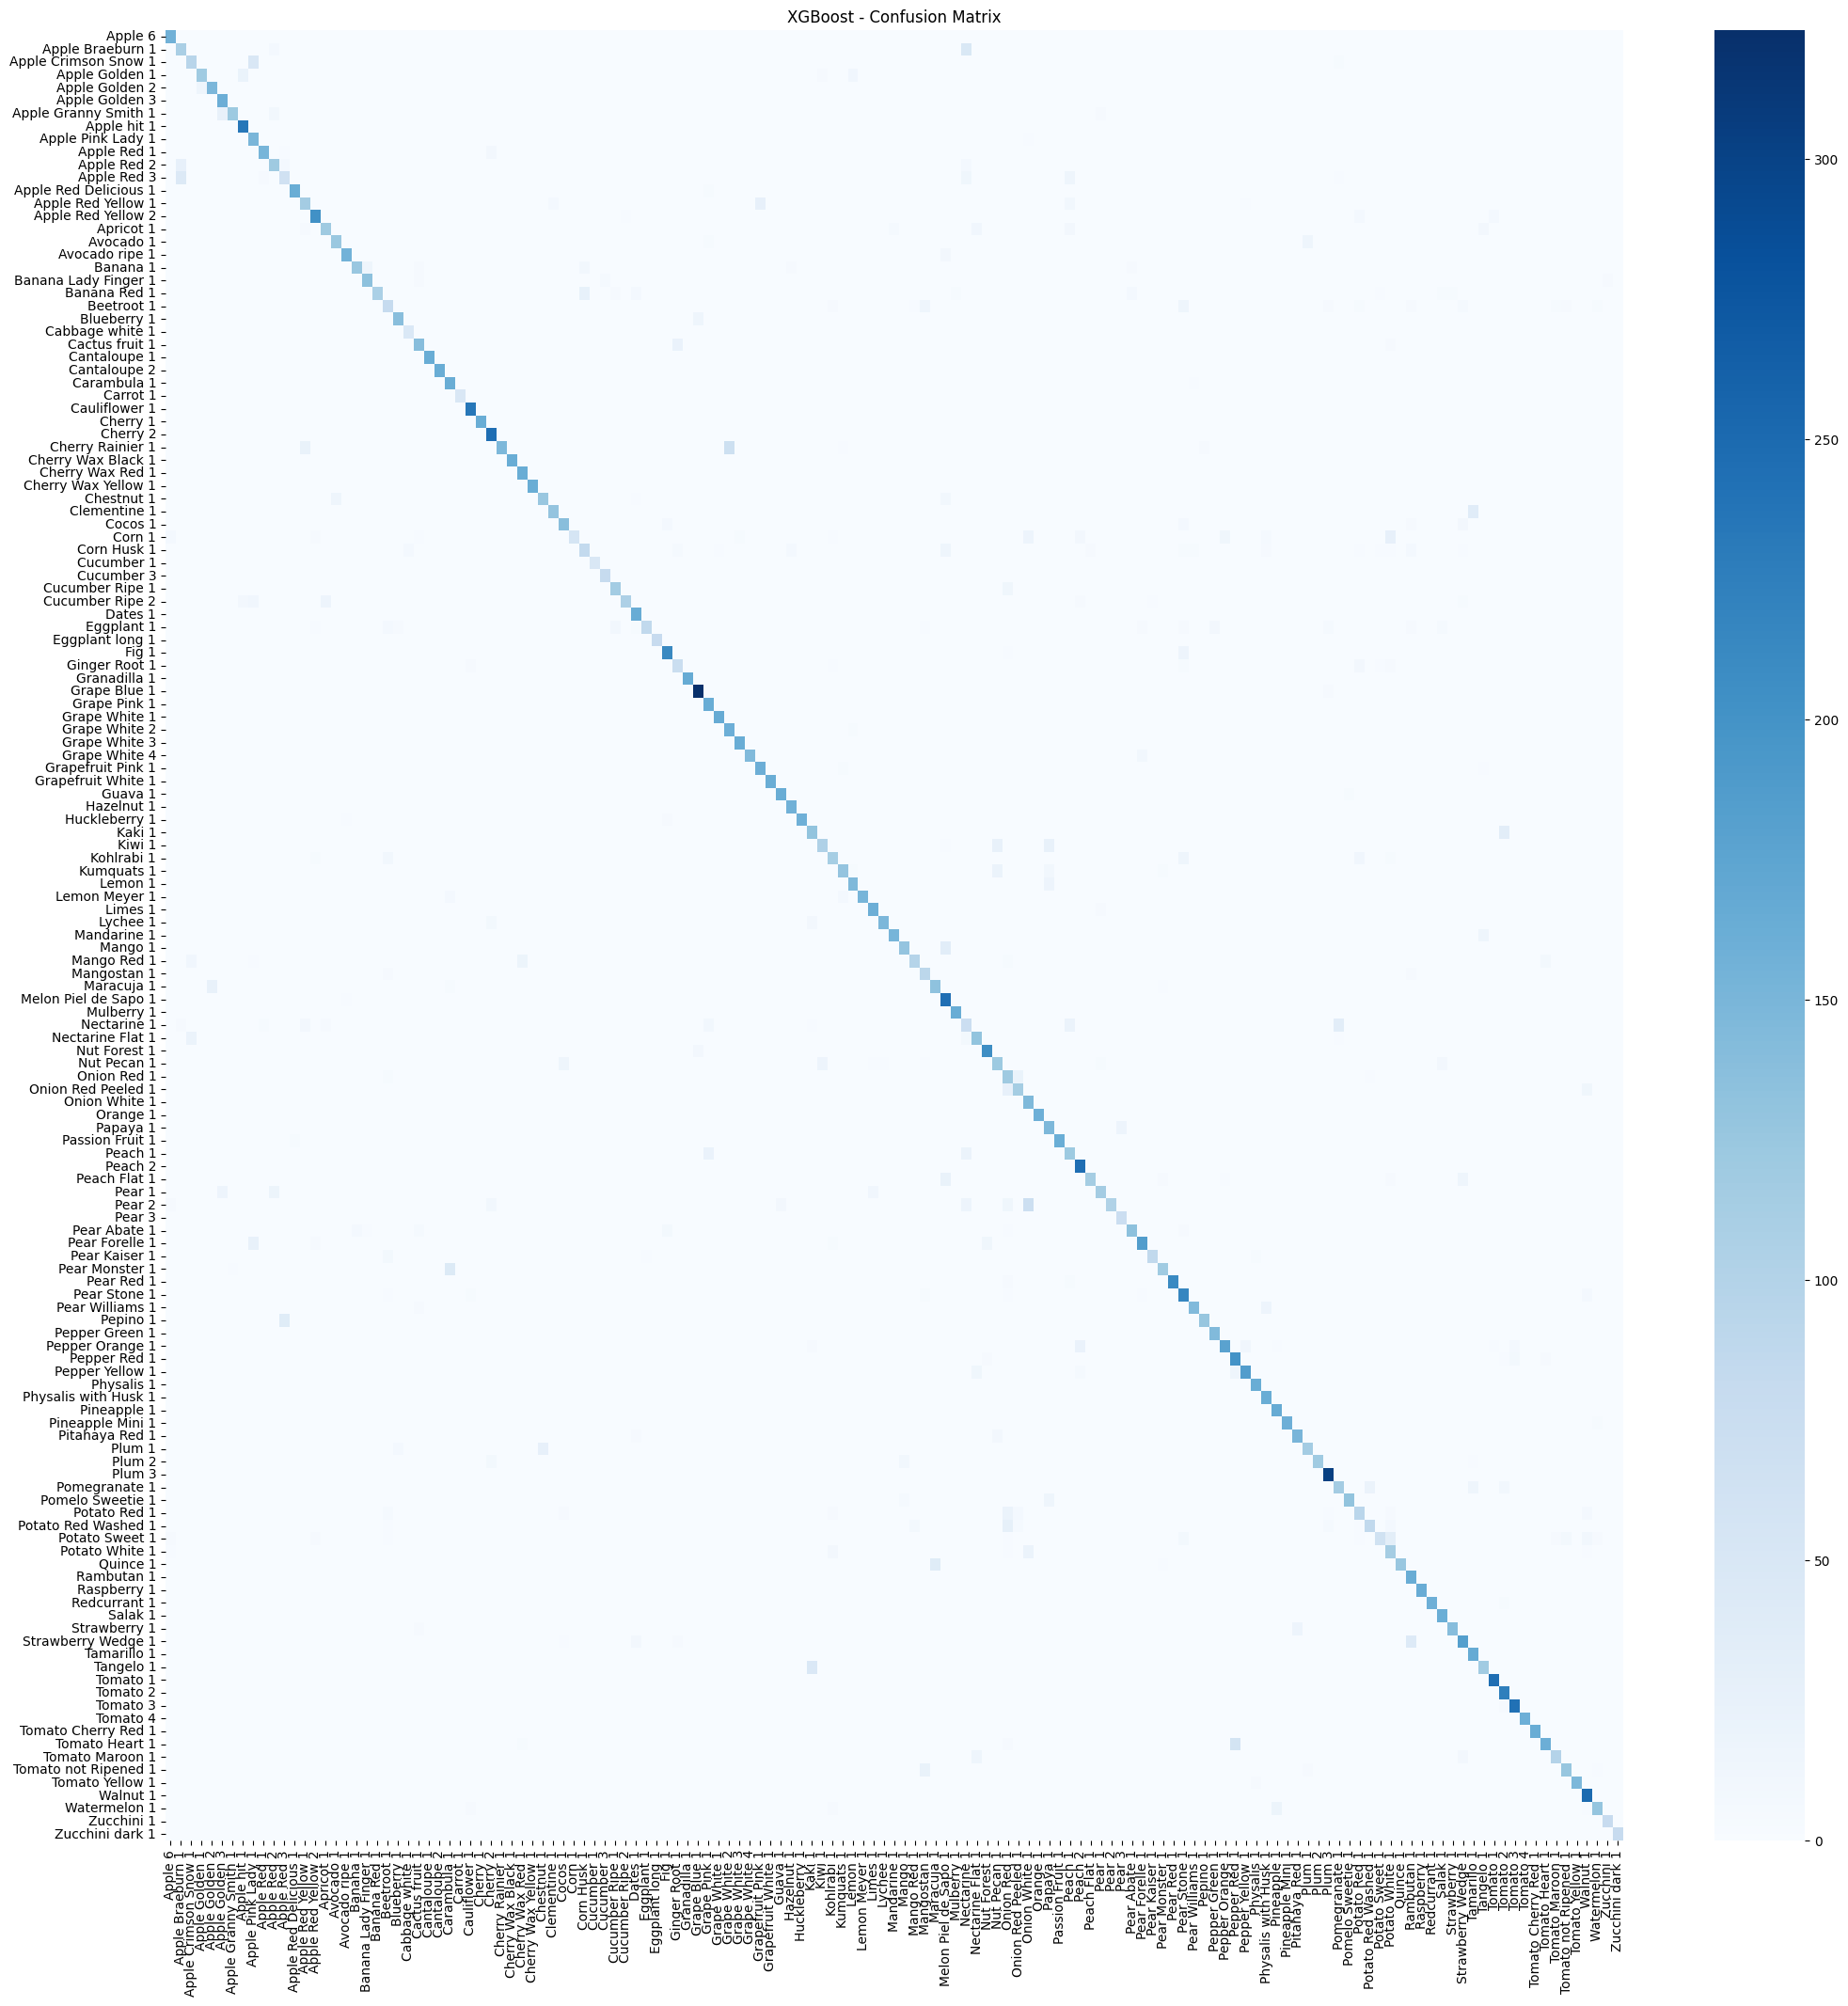

In [ ]:
xgb = XGBClassifier(n_estimators=400, max_depth=5, learning_rate=0.05, subsample=0.9, colsample_bytree=0.8)
xgb.fit(reduced_train_features_fruits, y_train_fruits)

y_pred_xgb = xgb.predict(reduced_test_features_fruits)

print("XGBoost Accuracy:", accuracy_score(y_test_fruits, y_pred_xgb))

print("Classification Report (XGBoost):")
print(classification_report(y_test_fruits, y_pred_xgb))

class_names = label_map_train.values()

cm_xgb = confusion_matrix(y_test_fruits, y_pred_xgb)
plt.figure(figsize=(25, 25))
sns.heatmap(cm_xgb, annot=False, cmap='Blues', cbar=True, xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=90)
plt.title('XGBoost - Confusion Matrix')
plt.show()

In [69]:
# Print the names of the classes for Fruit-360
print(label_map_train)

{0: 'Apple 6', 1: 'Apple Braeburn 1', 2: 'Apple Crimson Snow 1', 3: 'Apple Golden 1', 4: 'Apple Golden 2', 5: 'Apple Golden 3', 6: 'Apple Granny Smith 1', 7: 'Apple hit 1', 8: 'Apple Pink Lady 1', 9: 'Apple Red 1', 10: 'Apple Red 2', 11: 'Apple Red 3', 12: 'Apple Red Delicious 1', 13: 'Apple Red Yellow 1', 14: 'Apple Red Yellow 2', 15: 'Apricot 1', 16: 'Avocado 1', 17: 'Avocado ripe 1', 18: 'Banana 1', 19: 'Banana Lady Finger 1', 20: 'Banana Red 1', 21: 'Beetroot 1', 22: 'Blueberry 1', 23: 'Cabbage white 1', 24: 'Cactus fruit 1', 25: 'Cantaloupe 1', 26: 'Cantaloupe 2', 27: 'Carambula 1', 28: 'Carrot 1', 29: 'Cauliflower 1', 30: 'Cherry 1', 31: 'Cherry 2', 32: 'Cherry Rainier 1', 33: 'Cherry Wax Black 1', 34: 'Cherry Wax Red 1', 35: 'Cherry Wax Yellow 1', 36: 'Chestnut 1', 37: 'Clementine 1', 38: 'Cocos 1', 39: 'Corn 1', 40: 'Corn Husk 1', 41: 'Cucumber 1', 42: 'Cucumber 3', 43: 'Cucumber Ripe 1', 44: 'Cucumber Ripe 2', 45: 'Dates 1', 46: 'Eggplant 1', 47: 'Eggplant long 1', 48: 'Fig 1'